In [1]:
import numpy as np
from matplotlib import rcParams
# Increase the default DPI, and change the file type from png to pdf 
rcParams['savefig.dpi']           = 300
#rcParams['savefig.extension']     = "pdf"

# Simplify paths by removing "invisible" points, useful for reducing
# file size when plotting a large number of points
rcParams['path.simplify']         = True

# Instead of individually increasing font sizes, point sizes, and line 
# thicknesses, I found it easier to just decrease the figure size so
# that the line weights of various components still agree 
rcParams['figure.figsize']        = 4,4

# In this example I am *not* setting "text.usetex : True", therefore the     
# following ensures that the fonts in math mode agree with the regular ones.  
# 
rcParams['font.family']           = "serif"
rcParams['mathtext.fontset']      = "custom"
rcParams['errorbar.capsize']      = 3
#rcParams['text.usetex']           = True
rcParams['axes.linewidth']        = 2 
rcParams['font.weight']           = "bold"
#rcParams['text.latex.preamble']   = [r'\usepackage{sfmath} \boldmath']

# Increase the tick-mark lengths (defaults are 4 and 2)
rcParams['xtick.major.size']      = 6
rcParams['ytick.major.size']      = 6 
rcParams['xtick.minor.size']      = 3   
rcParams['ytick.minor.size']      = 3
rcParams['xtick.minor.visible']   = True
rcParams['ytick.minor.visible']   = True

rcParams['xtick.direction']      = "in"
rcParams['ytick.direction']      = "in" 
rcParams['xtick.top']      = True
rcParams['ytick.right']      = True 

# Increase the tick-mark widths as well as the widths of lines 
# used to draw marker edges to be consistent with the other figure
# linewidths (defaults are all 0.5)
rcParams['xtick.major.width']     = 1
rcParams['ytick.major.width']     = 1
rcParams['xtick.minor.width']     = 1
rcParams['ytick.minor.width']     = 1
rcParams['lines.markeredgewidth'] = 1

# Have the legend only plot one point instead of two, turn off the 
# frame, and reduce the space between the point and the label  
rcParams['legend.numpoints']      = 1
rcParams['legend.frameon']        = False
rcParams['legend.handletextpad']      = 0.3
import matplotlib.pyplot as plt
import math
import itertools
#import multiprocess as mp
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
import pandas as pd
import os
import sys
from scipy import stats
import json
import io
import ipopt
import subprocess

from numpy import pi, cos 
from pymultinest.solve import solve
from pymultinest.run import run
from pymultinest import Analyzer
import pymultinest
import contextlib
import corner
import osqp
import scipy as sp
from scipy import sparse
import copy

%matplotlib inline

ImportError: libopenblas.so.0: cannot open shared object file: No such file or directory

## Testing Ipopt Realization

In [2]:
from scipy.optimize import minimize 

In [40]:
day = Day - np.min(Day)

In [39]:
np.array([np.array([np.cos(pa),np.sin(pa),f[i]]) for i,pa in enumerate(PA)]).shape

(22, 3)

In [43]:
class rotfit(object):
    def __init__(self, pitch, sign):
        f = 1 / (Flux ** (4 / (2-1))) - 1
        f += abs(np.min(f))
        self.Y = np.array([np.array([np.cos(pa),np.sin(pa),f[i]]) for i,pa in enumerate(PA)])
        self.Y = (self.Y.T / np.linalg.norm(self.Y, axis=1)).T
        self.X = Bhelix((day*deg) * np.pi/180, pitch, sign)

    def objective(self, x):
        #
        # The callback for calculating the objective
        #
        u = x.reshape((3,3))
        return np.linalg.norm(np.diag(self.Y @ (u @ self.X)))**2

    def gradient(self, x):
        #
        # The callback for calculating the gradient
        #
        u = x.reshape((3,3))
        vec = np.diag(self.Y @ (u @ self.X))
        grad = lambda i,j: 2 * vec @ (self.Y[:,i] * self.X[j,:])
        return np.array([
                    grad(0,0),
                    grad(0,1),
                    grad(0,2),
                    grad(1,0),
                    grad(1,1),
                    grad(1,2),
                    grad(2,0),
                    grad(2,1),
                    grad(2,2),
                    ])

    def constraints(self, x):
        #
        # The callback for calculating the constraints
        #
        u = x.reshape((3,3))
        U = (u.T @ u)
        return np.array((U[0,0], U[1,1], U[2,2], U[0,1], U[0,2], U[2,1]))

    def jacobian(self, x):
        #
        # The callback for calculating the Jacobian
        #
        return np.concatenate( (np.array([2*x[0],2*x[1], 2*x[2],0,0,0,0,0,0]), 
                               np.array([0,0,0,2*x[3],2*x[4], 2*x[5],0,0,0]), 
                               np.array([0,0,0,0,0,0,2*x[6],2*x[7], 2*x[8]]), 
                               np.array([x[3],x[4],x[5],x[0],x[1],x[2],0,0,0]), 
                               np.array([x[6],x[7],x[8],0,0,0,x[0],x[1],x[2]]), 
                               np.array([0,0,0,x[6],x[7],x[8],x[4],x[5],x[6]])) )


    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        #
        # Example for the use of the intermediate callback.
        #
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

In [44]:
theta = 2.0
# x0 = [np.cos(theta), 0, np.sin(theta), 0, 1, 0, np.cos(theta), 0, -np.sin(theta)]
x0 = np.random.normal(size=9)

lb = [-1] * 9
ub = [1] * 9

cl = [1, 1, 1, 0, 0, 0]
cu = [1, 1, 1, 0, 0, 0]

best_obj = 10
best_x = None
best_pitch = None
for pitch in np.linspace(-4,4,100):
    nlp = ipopt.problem(
                n=len(x0),
                m=len(cl),
                problem_obj=rotfit(pitch=pitch,sign=-1),
                lb=lb,
                ub=ub,
                cl=cl,
                cu=cu
                )
    nlp.addOption('mu_strategy', 'adaptive')
    nlp.addOption('tol', 1e-7)
    
    x, info = nlp.solve(x0)
    if info['obj_val'] < best_obj:
        best_obj = info['obj_val']
        best_x = x
        best_pitch = pitch
print(best_obj)

Objective value at iteration #0 is - 3.86486
Objective value at iteration #1 is - 4.51366
Objective value at iteration #2 is - 6.96241
Objective value at iteration #3 is - 14.0453
Objective value at iteration #4 is - 13.5829
Objective value at iteration #5 is - 14.7301
Objective value at iteration #6 is - 14.9515
Objective value at iteration #7 is - 14.1494
Objective value at iteration #8 is - 14.1354
Objective value at iteration #9 is - 15.2607
Objective value at iteration #10 is - 15.0742
Objective value at iteration #11 is - 16.2278
Objective value at iteration #12 is - 17.0692
Objective value at iteration #13 is - 17.4432
Objective value at iteration #14 is - 18.2632
Objective value at iteration #15 is - 19.7786
Objective value at iteration #16 is - 19.83
Objective value at iteration #17 is - 21.154
Objective value at iteration #18 is - 21.094
Objective value at iteration #19 is - 21.448
Objective value at iteration #20 is - 21.6315
Objective value at iteration #21 is - 21.5494
Obj

Objective value at iteration #171 is - 6.35721
Objective value at iteration #172 is - 7.56323
Objective value at iteration #173 is - 8.63496
Objective value at iteration #174 is - 8.53239
Objective value at iteration #175 is - 7.87176
Objective value at iteration #176 is - 7.11282
Objective value at iteration #177 is - 6.97454
Objective value at iteration #178 is - 6.96094
Objective value at iteration #179 is - 6.96094
Objective value at iteration #180 is - 19.5845
Objective value at iteration #181 is - 15.1536
Objective value at iteration #182 is - 7.53936
Objective value at iteration #182 is - 7.53936
Objective value at iteration #183 is - 5.97037
Objective value at iteration #184 is - 4.96304
Objective value at iteration #185 is - 5.72249
Objective value at iteration #186 is - 5.43048
Objective value at iteration #187 is - 4.75278
Objective value at iteration #188 is - 5.43077
Objective value at iteration #189 is - 4.91656
Objective value at iteration #190 is - 7.50783
Objective val

Objective value at iteration #32 is - 12.4101
Objective value at iteration #33 is - 9.32273
Objective value at iteration #34 is - 10.1802
Objective value at iteration #35 is - 10.5834
Objective value at iteration #36 is - 10.751
Objective value at iteration #37 is - 10.8429
Objective value at iteration #38 is - 10.8608
Objective value at iteration #39 is - 13.5366
Objective value at iteration #40 is - 10.5906
Objective value at iteration #41 is - 11.3775
Objective value at iteration #42 is - 11.9109
Objective value at iteration #43 is - 12.015
Objective value at iteration #44 is - 12.015
Objective value at iteration #45 is - 12.1176
Objective value at iteration #45 is - 12.1176
Objective value at iteration #46 is - 11.1971
Objective value at iteration #47 is - 8.87274
Objective value at iteration #48 is - 15.3971
Objective value at iteration #49 is - 11.0369
Objective value at iteration #50 is - 13.6167
Objective value at iteration #51 is - 13.6167
Objective value at iteration #52 is -

Objective value at iteration #73 is - 6.75931
Objective value at iteration #74 is - 13.3255
Objective value at iteration #75 is - 5.77951
Objective value at iteration #76 is - 5.03101
Objective value at iteration #77 is - 8.12703
Objective value at iteration #78 is - 7.29043
Objective value at iteration #79 is - 6.93487
Objective value at iteration #80 is - 5.60499
Objective value at iteration #81 is - 4.05974
Objective value at iteration #82 is - 4.05974
Objective value at iteration #83 is - 3.41084
Objective value at iteration #84 is - 3.54591
Objective value at iteration #85 is - 3.93039
Objective value at iteration #86 is - 5.35481
Objective value at iteration #87 is - 6.69406
Objective value at iteration #88 is - 6.83948
Objective value at iteration #89 is - 6.6685
Objective value at iteration #90 is - 5.22456
Objective value at iteration #91 is - 4.63787
Objective value at iteration #92 is - 5.49661
Objective value at iteration #93 is - 5.53397
Objective value at iteration #94 is

Objective value at iteration #214 is - 6.52227
Objective value at iteration #215 is - 6.52227
Objective value at iteration #216 is - 6.49601
Objective value at iteration #216 is - 6.49601
Objective value at iteration #217 is - 11.6622
Objective value at iteration #218 is - 10.4186
Objective value at iteration #219 is - 12.8292
Objective value at iteration #220 is - 12.5462
Objective value at iteration #221 is - 12.5462
Objective value at iteration #222 is - 13.6015
Objective value at iteration #223 is - 11.3599
Objective value at iteration #224 is - 15.1728
Objective value at iteration #225 is - 18.8506
Objective value at iteration #226 is - 19.4345
Objective value at iteration #227 is - 13.6915
Objective value at iteration #228 is - 14.4979
Objective value at iteration #229 is - 10.0937
Objective value at iteration #230 is - 9.53683
Objective value at iteration #231 is - 9.36333
Objective value at iteration #232 is - 5.17463
Objective value at iteration #233 is - 1.90122
Objective val

Objective value at iteration #50 is - 7.82535
Objective value at iteration #50 is - 7.82535
Objective value at iteration #51 is - 8.3745
Objective value at iteration #52 is - 8.3745
Objective value at iteration #53 is - 8.06289
Objective value at iteration #54 is - 8.7566
Objective value at iteration #55 is - 7.27901
Objective value at iteration #55 is - 7.27901
Objective value at iteration #56 is - 6.44012
Objective value at iteration #57 is - 5.74451
Objective value at iteration #58 is - 5.09581
Objective value at iteration #59 is - 5.09581
Objective value at iteration #60 is - 3.5197
Objective value at iteration #61 is - 9.31206
Objective value at iteration #62 is - 2.42009
Objective value at iteration #63 is - 2.46393
Objective value at iteration #63 is - 2.46393
Objective value at iteration #64 is - 12.6986
Objective value at iteration #65 is - 9.24748
Objective value at iteration #66 is - 9.16419
Objective value at iteration #67 is - 8.96868
Objective value at iteration #68 is - 

Objective value at iteration #0 is - 3.41023
Objective value at iteration #1 is - 4.67487
Objective value at iteration #2 is - 6.93251
Objective value at iteration #3 is - 9.2964
Objective value at iteration #4 is - 9.30162
Objective value at iteration #5 is - 10.1564
Objective value at iteration #6 is - 10.2317
Objective value at iteration #7 is - 10.9186
Objective value at iteration #8 is - 9.36965
Objective value at iteration #9 is - 7.31071
Objective value at iteration #10 is - 6.51696
Objective value at iteration #11 is - 5.29145
Objective value at iteration #12 is - 4.60499
Objective value at iteration #13 is - 4.08504
Objective value at iteration #14 is - 4.08504
Objective value at iteration #15 is - 2.47651
Objective value at iteration #16 is - 4.62065
Objective value at iteration #16 is - 4.62065
Objective value at iteration #17 is - 3.92418
Objective value at iteration #18 is - 4.09063
Objective value at iteration #19 is - 4.09063
Objective value at iteration #20 is - 10.0119

Objective value at iteration #26 is - 5.10186
Objective value at iteration #26 is - 5.10186
Objective value at iteration #27 is - 4.06988
Objective value at iteration #28 is - 4.5012
Objective value at iteration #29 is - 4.86057
Objective value at iteration #30 is - 4.25228
Objective value at iteration #31 is - 5.28989
Objective value at iteration #32 is - 5.41297
Objective value at iteration #33 is - 5.41081
Objective value at iteration #34 is - 5.41081
Objective value at iteration #35 is - 9.26841
Objective value at iteration #36 is - 9.0795
Objective value at iteration #37 is - 8.77134
Objective value at iteration #38 is - 7.86394
Objective value at iteration #39 is - 8.0208
Objective value at iteration #40 is - 7.7186
Objective value at iteration #40 is - 7.7186
Objective value at iteration #41 is - 7.30483
Objective value at iteration #42 is - 8.71958
Objective value at iteration #43 is - 11.4348
Objective value at iteration #44 is - 12.8177
Objective value at iteration #45 is - 1

Objective value at iteration #25 is - 7.24764
Objective value at iteration #26 is - 7.04076
Objective value at iteration #27 is - 6.91887
Objective value at iteration #28 is - 6.9246
Objective value at iteration #29 is - 6.93238
Objective value at iteration #30 is - 6.93238
Objective value at iteration #31 is - 6.81835
Objective value at iteration #31 is - 6.81835
Objective value at iteration #32 is - 6.81835
Objective value at iteration #33 is - 6.47751
Objective value at iteration #33 is - 6.47751
Objective value at iteration #34 is - 6.33664
Objective value at iteration #35 is - 5.90448
Objective value at iteration #36 is - 5.6921
Objective value at iteration #37 is - 5.91655
Objective value at iteration #38 is - 5.85355
Objective value at iteration #39 is - 9.19956
Objective value at iteration #40 is - 9.19956
Objective value at iteration #41 is - 7.59167
Objective value at iteration #42 is - 8.00204
Objective value at iteration #43 is - 8.27321
Objective value at iteration #44 is 

Objective value at iteration #28 is - 7.45293
Objective value at iteration #29 is - 10.373
Objective value at iteration #30 is - 12.0136
Objective value at iteration #31 is - 11.0855
Objective value at iteration #32 is - 12.0157
Objective value at iteration #33 is - 11.6625
Objective value at iteration #34 is - 11.1913
Objective value at iteration #35 is - 10.807
Objective value at iteration #36 is - 10.807
Objective value at iteration #37 is - 6.50414
Objective value at iteration #37 is - 6.50414
Objective value at iteration #38 is - 8.55521
Objective value at iteration #39 is - 7.10813
Objective value at iteration #40 is - 7.10813
Objective value at iteration #41 is - 8.37939
Objective value at iteration #42 is - 5.52057
Objective value at iteration #43 is - 8.4047
Objective value at iteration #43 is - 8.4047
Objective value at iteration #44 is - 8.63525
Objective value at iteration #45 is - 8.59673
Objective value at iteration #46 is - 8.22473
Objective value at iteration #47 is - 8

Objective value at iteration #37 is - 5.83449
Objective value at iteration #38 is - 5.6849
Objective value at iteration #39 is - 5.62665
Objective value at iteration #40 is - 6.06945
Objective value at iteration #41 is - 7.08039
Objective value at iteration #42 is - 6.8711
Objective value at iteration #43 is - 6.76984
Objective value at iteration #44 is - 5.42316
Objective value at iteration #45 is - 5.16328
Objective value at iteration #46 is - 5.78697
Objective value at iteration #47 is - 5.90198
Objective value at iteration #48 is - 6.82877
Objective value at iteration #49 is - 7.45581
Objective value at iteration #50 is - 6.11448
Objective value at iteration #51 is - 5.14415
Objective value at iteration #52 is - 4.72174
Objective value at iteration #53 is - 6.10529
Objective value at iteration #54 is - 6.59451
Objective value at iteration #55 is - 5.0101
Objective value at iteration #56 is - 3.82449
Objective value at iteration #57 is - 3.82449
Objective value at iteration #58 is -

Objective value at iteration #14 is - 13.6668
Objective value at iteration #15 is - 10.2734
Objective value at iteration #16 is - 10.3147
Objective value at iteration #17 is - 7.90264
Objective value at iteration #18 is - 8.71046
Objective value at iteration #18 is - 8.71046
Objective value at iteration #19 is - 9.54207
Objective value at iteration #20 is - 11.1041
Objective value at iteration #21 is - 10.9693
Objective value at iteration #22 is - 10.8917
Objective value at iteration #23 is - 12.2251
Objective value at iteration #24 is - 12.2251
Objective value at iteration #25 is - 8.74196
Objective value at iteration #25 is - 8.74196
Objective value at iteration #26 is - 8.11853
Objective value at iteration #27 is - 6.59716
Objective value at iteration #28 is - 7.02059
Objective value at iteration #29 is - 7.02059
Objective value at iteration #30 is - 9.21467
Objective value at iteration #31 is - 7.70589
Objective value at iteration #32 is - 9.33691
Objective value at iteration #33 i

Objective value at iteration #176 is - 7.07312
Objective value at iteration #177 is - 6.67844
Objective value at iteration #178 is - 6.67844
Objective value at iteration #179 is - 6.48269
Objective value at iteration #180 is - 6.55034
Objective value at iteration #181 is - 6.47294
Objective value at iteration #182 is - 5.51381
Objective value at iteration #183 is - 7.1109
Objective value at iteration #184 is - 9.66261
Objective value at iteration #185 is - 9.89546
Objective value at iteration #186 is - 10.8463
Objective value at iteration #187 is - 12.0247
Objective value at iteration #188 is - 11.8755
Objective value at iteration #189 is - 11.4472
Objective value at iteration #190 is - 9.06649
Objective value at iteration #191 is - 6.62859
Objective value at iteration #192 is - 4.99851
Objective value at iteration #192 is - 4.99851
Objective value at iteration #193 is - 3.89164
Objective value at iteration #194 is - 3.47584
Objective value at iteration #195 is - 3.47584
Objective valu

Objective value at iteration #70 is - 4.00326
Objective value at iteration #71 is - 3.72184
Objective value at iteration #72 is - 3.86557
Objective value at iteration #73 is - 5.32149
Objective value at iteration #74 is - 6.61548
Objective value at iteration #75 is - 6.62957
Objective value at iteration #76 is - 6.62957
Objective value at iteration #77 is - 7.74618
Objective value at iteration #78 is - 7.73521
Objective value at iteration #79 is - 7.50238
Objective value at iteration #80 is - 7.49971
Objective value at iteration #81 is - 7.43625
Objective value at iteration #82 is - 4.00869
Objective value at iteration #83 is - 3.98316
Objective value at iteration #84 is - 3.80056
Objective value at iteration #85 is - 4.27029
Objective value at iteration #86 is - 4.23564
Objective value at iteration #87 is - 4.06919
Objective value at iteration #88 is - 3.59714
Objective value at iteration #89 is - 3.70989
Objective value at iteration #90 is - 5.4769
Objective value at iteration #91 is

Objective value at iteration #122 is - 6.36145
Objective value at iteration #123 is - 6.36398
Objective value at iteration #124 is - 6.59708
Objective value at iteration #125 is - 7.27112
Objective value at iteration #126 is - 5.57811
Objective value at iteration #127 is - 9.74883
Objective value at iteration #128 is - 12.8336
Objective value at iteration #129 is - 7.3582
Objective value at iteration #130 is - 6.75797
Objective value at iteration #131 is - 3.60589
Objective value at iteration #132 is - 11.6387
Objective value at iteration #133 is - 10.2632
Objective value at iteration #134 is - 4.74563
Objective value at iteration #135 is - 3.32509
Objective value at iteration #136 is - 5.0193
Objective value at iteration #137 is - 8.41057
Objective value at iteration #138 is - 8.09666
Objective value at iteration #139 is - 7.67962
Objective value at iteration #140 is - 11.0421
Objective value at iteration #141 is - 6.40646
Objective value at iteration #142 is - 5.43317
Objective value

Objective value at iteration #149 is - 8.84553
Objective value at iteration #150 is - 8.6287
Objective value at iteration #151 is - 9.03183
Objective value at iteration #152 is - 8.74725
Objective value at iteration #153 is - 8.38388
Objective value at iteration #154 is - 8.48833
Objective value at iteration #155 is - 8.26876
Objective value at iteration #156 is - 8.32632
Objective value at iteration #157 is - 8.38844
Objective value at iteration #158 is - 8.37534
Objective value at iteration #159 is - 8.37754
Objective value at iteration #160 is - 8.37465
Objective value at iteration #161 is - 8.37318
Objective value at iteration #162 is - 8.37323
Objective value at iteration #163 is - 8.37347
Objective value at iteration #164 is - 8.37364
Objective value at iteration #165 is - 8.37364
Objective value at iteration #166 is - 8.37361
Objective value at iteration #167 is - 8.3736
Objective value at iteration #168 is - 8.3736
Objective value at iteration #169 is - 8.3736
Objective value a

Objective value at iteration #58 is - 6.27439
Objective value at iteration #59 is - 7.82521
Objective value at iteration #60 is - 8.53945
Objective value at iteration #61 is - 7.81121
Objective value at iteration #62 is - 10.9045
Objective value at iteration #63 is - 10.5525
Objective value at iteration #64 is - 9.66433
Objective value at iteration #65 is - 8.59291
Objective value at iteration #66 is - 8.79227
Objective value at iteration #67 is - 8.22718
Objective value at iteration #68 is - 7.07522
Objective value at iteration #69 is - 7.90097
Objective value at iteration #70 is - 9.54654
Objective value at iteration #71 is - 5.68284
Objective value at iteration #72 is - 7.63093
Objective value at iteration #73 is - 7.94976
Objective value at iteration #74 is - 8.73336
Objective value at iteration #75 is - 9.48641
Objective value at iteration #76 is - 8.24088
Objective value at iteration #77 is - 8.83579
Objective value at iteration #78 is - 8.55627
Objective value at iteration #79 i

Objective value at iteration #57 is - 11.9592
Objective value at iteration #58 is - 11.9592
Objective value at iteration #59 is - 12.1409
Objective value at iteration #60 is - 16.0896
Objective value at iteration #61 is - 15.8388
Objective value at iteration #62 is - 14.7706
Objective value at iteration #63 is - 18.8106
Objective value at iteration #64 is - 15.2894
Objective value at iteration #65 is - 14.8368
Objective value at iteration #66 is - 11.1329
Objective value at iteration #67 is - 9.94858
Objective value at iteration #68 is - 6.32635
Objective value at iteration #69 is - 5.36204
Objective value at iteration #70 is - 4.99916
Objective value at iteration #71 is - 6.17358
Objective value at iteration #72 is - 5.8721
Objective value at iteration #73 is - 5.87545
Objective value at iteration #74 is - 5.95067
Objective value at iteration #75 is - 7.10617
Objective value at iteration #76 is - 7.64224
Objective value at iteration #77 is - 7.64224
Objective value at iteration #78 is

Objective value at iteration #68 is - 4.16846
Objective value at iteration #69 is - 5.28063
Objective value at iteration #70 is - 5.34235
Objective value at iteration #71 is - 5.67622
Objective value at iteration #72 is - 5.56885
Objective value at iteration #73 is - 5.20163
Objective value at iteration #74 is - 4.04411
Objective value at iteration #75 is - 4.22097
Objective value at iteration #76 is - 4.68551
Objective value at iteration #77 is - 4.37767
Objective value at iteration #78 is - 4.31505
Objective value at iteration #79 is - 4.4282
Objective value at iteration #80 is - 4.45145
Objective value at iteration #81 is - 4.43829
Objective value at iteration #82 is - 4.43681
Objective value at iteration #83 is - 4.43729
Objective value at iteration #84 is - 4.43828
Objective value at iteration #85 is - 4.43924
Objective value at iteration #86 is - 4.43819
Objective value at iteration #87 is - 4.43825
Objective value at iteration #88 is - 4.43849
Objective value at iteration #89 is

Objective value at iteration #165 is - 8.49177
Objective value at iteration #166 is - 7.72824
Objective value at iteration #167 is - 9.04837
Objective value at iteration #168 is - 6.68082
Objective value at iteration #169 is - 4.19441
Objective value at iteration #170 is - 5.68241
Objective value at iteration #171 is - 4.1061
Objective value at iteration #172 is - 3.54838
Objective value at iteration #173 is - 3.56677
Objective value at iteration #174 is - 5.71823
Objective value at iteration #174 is - 5.71823
Objective value at iteration #175 is - 6.04283
Objective value at iteration #176 is - 6.21104
Objective value at iteration #177 is - 5.78589
Objective value at iteration #178 is - 5.4117
Objective value at iteration #179 is - 5.22005
Objective value at iteration #180 is - 5.22005
Objective value at iteration #181 is - 6.42111
Objective value at iteration #182 is - 3.92139
Objective value at iteration #183 is - 4.70646
Objective value at iteration #184 is - 4.80044
Objective value

Objective value at iteration #402 is - 6.73383
Objective value at iteration #403 is - 6.73459
Objective value at iteration #404 is - 6.73471
Objective value at iteration #405 is - 6.73479
Objective value at iteration #406 is - 6.73466
Objective value at iteration #407 is - 6.73465
Objective value at iteration #408 is - 6.73471
Objective value at iteration #409 is - 6.73471
Objective value at iteration #410 is - 6.73469
Objective value at iteration #411 is - 6.73469
Objective value at iteration #412 is - 6.73469
Objective value at iteration #413 is - 6.73471
Objective value at iteration #414 is - 6.73471
Objective value at iteration #415 is - 6.73471
Objective value at iteration #416 is - 6.73472
Objective value at iteration #417 is - 6.73472
Objective value at iteration #418 is - 6.73472
Objective value at iteration #419 is - 6.73472
Objective value at iteration #420 is - 6.73472
Objective value at iteration #421 is - 6.73472
Objective value at iteration #422 is - 6.73472
Objective val

Objective value at iteration #142 is - 9.03882
Objective value at iteration #143 is - 9.03882
Objective value at iteration #144 is - 9.03882
Objective value at iteration #145 is - 9.03882
Objective value at iteration #146 is - 9.03882
Objective value at iteration #147 is - 9.03882
Objective value at iteration #148 is - 9.03882
Objective value at iteration #149 is - 9.03882
Objective value at iteration #0 is - 2.49359
Objective value at iteration #1 is - 2.86065
Objective value at iteration #2 is - 4.98684
Objective value at iteration #3 is - 6.618
Objective value at iteration #4 is - 14.8495
Objective value at iteration #5 is - 15.171
Objective value at iteration #6 is - 15.1896
Objective value at iteration #7 is - 15.2163
Objective value at iteration #8 is - 15.95
Objective value at iteration #9 is - 17.0057
Objective value at iteration #10 is - 17.6226
Objective value at iteration #11 is - 14.0454
Objective value at iteration #12 is - 14.2884
Objective value at iteration #13 is - 13.

Objective value at iteration #41 is - 5.36019
Objective value at iteration #42 is - 4.57395
Objective value at iteration #43 is - 3.68063
Objective value at iteration #44 is - 4.08637
Objective value at iteration #45 is - 5.06414
Objective value at iteration #46 is - 7.10375
Objective value at iteration #47 is - 7.54385
Objective value at iteration #48 is - 7.78691
Objective value at iteration #49 is - 9.50512
Objective value at iteration #50 is - 9.90425
Objective value at iteration #51 is - 6.86384
Objective value at iteration #51 is - 6.86384
Objective value at iteration #52 is - 6.84907
Objective value at iteration #53 is - 7.54208
Objective value at iteration #54 is - 7.50173
Objective value at iteration #55 is - 7.4153
Objective value at iteration #56 is - 9.50056
Objective value at iteration #57 is - 6.67897
Objective value at iteration #58 is - 10.1921
Objective value at iteration #59 is - 8.99682
Objective value at iteration #60 is - 7.74194
Objective value at iteration #61 is

Objective value at iteration #5 is - 14.7094
Objective value at iteration #6 is - 13.5188
Objective value at iteration #7 is - 13.5188
Objective value at iteration #8 is - 7.83016
Objective value at iteration #8 is - 7.83016
Objective value at iteration #9 is - 6.31259
Objective value at iteration #10 is - 4.97202
Objective value at iteration #11 is - 4.27984
Objective value at iteration #12 is - 3.54432
Objective value at iteration #13 is - 8.82306
Objective value at iteration #14 is - 5.93051
Objective value at iteration #15 is - 5.06711
Objective value at iteration #16 is - 4.4081
Objective value at iteration #17 is - 4.08731
Objective value at iteration #18 is - 4.08731
Objective value at iteration #19 is - 4.93031
Objective value at iteration #20 is - 6.13456
Objective value at iteration #21 is - 6.29162
Objective value at iteration #22 is - 9.53911
Objective value at iteration #23 is - 9.71346
Objective value at iteration #24 is - 11.9225
Objective value at iteration #25 is - 7.5

Objective value at iteration #128 is - 4.90629
Objective value at iteration #129 is - 6.34229
Objective value at iteration #130 is - 7.87944
Objective value at iteration #131 is - 5.78304
Objective value at iteration #132 is - 5.76167
Objective value at iteration #133 is - 7.82806
Objective value at iteration #134 is - 8.0276
Objective value at iteration #135 is - 9.18248
Objective value at iteration #136 is - 9.08854
Objective value at iteration #137 is - 7.81472
Objective value at iteration #138 is - 6.98502
Objective value at iteration #139 is - 16.8941
Objective value at iteration #140 is - 17.0145
Objective value at iteration #140 is - 17.0145
Objective value at iteration #141 is - 14.3198
Objective value at iteration #142 is - 13.582
Objective value at iteration #143 is - 13.5776
Objective value at iteration #144 is - 12.734
Objective value at iteration #145 is - 12.3626
Objective value at iteration #146 is - 12.1731
Objective value at iteration #147 is - 12.0841
Objective value 

Objective value at iteration #35 is - 5.59811
Objective value at iteration #36 is - 10.4888
Objective value at iteration #37 is - 9.85198
Objective value at iteration #38 is - 11.8449
Objective value at iteration #39 is - 11.1493
Objective value at iteration #40 is - 9.26263
Objective value at iteration #41 is - 8.31623
Objective value at iteration #42 is - 5.6929
Objective value at iteration #43 is - 7.25326
Objective value at iteration #44 is - 8.82513
Objective value at iteration #45 is - 10.1237
Objective value at iteration #46 is - 9.85607
Objective value at iteration #47 is - 9.61731
Objective value at iteration #48 is - 9.6443
Objective value at iteration #49 is - 9.44535
Objective value at iteration #50 is - 9.52606
Objective value at iteration #51 is - 9.48445
Objective value at iteration #52 is - 9.48782
Objective value at iteration #53 is - 9.49571
Objective value at iteration #54 is - 9.49662
Objective value at iteration #55 is - 9.49776
Objective value at iteration #56 is 

Objective value at iteration #158 is - 6.06169
Objective value at iteration #159 is - 6.05797
Objective value at iteration #160 is - 6.05687
Objective value at iteration #161 is - 5.9853
Objective value at iteration #162 is - 5.99306
Objective value at iteration #163 is - 5.96304
Objective value at iteration #164 is - 5.96304
Objective value at iteration #165 is - 4.24365
Objective value at iteration #165 is - 4.24365
Objective value at iteration #166 is - 4.19372
Objective value at iteration #167 is - 6.73952
Objective value at iteration #168 is - 6.70581
Objective value at iteration #169 is - 6.69357
Objective value at iteration #170 is - 6.68998
Objective value at iteration #171 is - 6.68937
Objective value at iteration #172 is - 6.68918
Objective value at iteration #173 is - 6.68911
Objective value at iteration #174 is - 6.96869
Objective value at iteration #175 is - 7.42104
Objective value at iteration #176 is - 8.53668
Objective value at iteration #177 is - 8.54752
Objective valu

Objective value at iteration #14 is - 8.86081
Objective value at iteration #15 is - 8.57757
Objective value at iteration #16 is - 8.34541
Objective value at iteration #17 is - 8.34541
Objective value at iteration #18 is - 3.85594
Objective value at iteration #18 is - 3.85594
Objective value at iteration #19 is - 3.21807
Objective value at iteration #20 is - 7.12809
Objective value at iteration #21 is - 4.89469
Objective value at iteration #22 is - 5.6658
Objective value at iteration #23 is - 6.68201
Objective value at iteration #24 is - 6.89238
Objective value at iteration #25 is - 6.98983
Objective value at iteration #26 is - 7.01119
Objective value at iteration #27 is - 7.01119
Objective value at iteration #28 is - 8.26798
Objective value at iteration #29 is - 8.16398
Objective value at iteration #30 is - 8.44488
Objective value at iteration #31 is - 9.01514
Objective value at iteration #32 is - 9.01514
Objective value at iteration #33 is - 7.93037
Objective value at iteration #34 is

Objective value at iteration #60 is - 13.2116
Objective value at iteration #61 is - 7.21748
Objective value at iteration #61 is - 7.21748
Objective value at iteration #62 is - 7.68508
Objective value at iteration #63 is - 7.63009
Objective value at iteration #64 is - 7.41738
Objective value at iteration #65 is - 7.41738
Objective value at iteration #66 is - 4.87822
Objective value at iteration #67 is - 8.5228
Objective value at iteration #68 is - 6.3251
Objective value at iteration #69 is - 7.06206
Objective value at iteration #70 is - 15.7677
Objective value at iteration #71 is - 13.5135
Objective value at iteration #72 is - 9.85636
Objective value at iteration #73 is - 11.4223
Objective value at iteration #74 is - 12.9481
Objective value at iteration #75 is - 14.9474
Objective value at iteration #76 is - 20.0908
Objective value at iteration #77 is - 20.2494
Objective value at iteration #78 is - 18.2003
Objective value at iteration #79 is - 17.4721
Objective value at iteration #80 is 

Objective value at iteration #6 is - 8.33459
Objective value at iteration #7 is - 8.6748
Objective value at iteration #8 is - 8.6748
Objective value at iteration #9 is - 6.19145
Objective value at iteration #9 is - 6.19145
Objective value at iteration #10 is - 6.19145
Objective value at iteration #11 is - 5.74348
Objective value at iteration #12 is - 3.03654
Objective value at iteration #13 is - 5.98275
Objective value at iteration #14 is - 7.43097
Objective value at iteration #15 is - 9.69135
Objective value at iteration #16 is - 17.4241
Objective value at iteration #17 is - 15.2162
Objective value at iteration #18 is - 10.4598
Objective value at iteration #19 is - 4.7867
Objective value at iteration #19 is - 4.7867
Objective value at iteration #20 is - 6.34889
Objective value at iteration #21 is - 6.67452
Objective value at iteration #22 is - 6.24543
Objective value at iteration #23 is - 3.89894
Objective value at iteration #24 is - 3.00552
Objective value at iteration #25 is - 2.397

Objective value at iteration #86 is - 9.48472
Objective value at iteration #87 is - 9.91773
Objective value at iteration #88 is - 10.0697
Objective value at iteration #89 is - 10.1746
Objective value at iteration #90 is - 9.9851
Objective value at iteration #91 is - 10.0509
Objective value at iteration #92 is - 10.0555
Objective value at iteration #93 is - 10.0621
Objective value at iteration #94 is - 10.0573
Objective value at iteration #95 is - 10.0586
Objective value at iteration #96 is - 10.0596
Objective value at iteration #97 is - 10.0593
Objective value at iteration #98 is - 10.0594
Objective value at iteration #99 is - 10.0593
Objective value at iteration #100 is - 10.0593
Objective value at iteration #101 is - 10.0593
Objective value at iteration #102 is - 10.0593
Objective value at iteration #103 is - 10.0593
Objective value at iteration #104 is - 10.0593
Objective value at iteration #105 is - 10.0593
Objective value at iteration #106 is - 10.0593
Objective value at iteration

Objective value at iteration #7 is - 11.2427
Objective value at iteration #8 is - 4.99886
Objective value at iteration #9 is - 8.47117
Objective value at iteration #10 is - 8.90196
Objective value at iteration #11 is - 9.17619
Objective value at iteration #12 is - 9.85991
Objective value at iteration #13 is - 10.1535
Objective value at iteration #14 is - 7.51515
Objective value at iteration #15 is - 6.83638
Objective value at iteration #16 is - 7.6409
Objective value at iteration #17 is - 9.17431
Objective value at iteration #18 is - 13.2737
Objective value at iteration #19 is - 11.8096
Objective value at iteration #20 is - 12.0423
Objective value at iteration #21 is - 12.031
Objective value at iteration #22 is - 12.031
Objective value at iteration #23 is - 9.21095
Objective value at iteration #24 is - 9.09411
Objective value at iteration #24 is - 9.09411
Objective value at iteration #25 is - 9.09411
Objective value at iteration #26 is - 9.41749
Objective value at iteration #27 is - 9.

Objective value at iteration #47 is - 8.81071
Objective value at iteration #47 is - 8.81071
Objective value at iteration #48 is - 10.7108
Objective value at iteration #49 is - 10.7752
Objective value at iteration #50 is - 10.7752
Objective value at iteration #51 is - 12.1171
Objective value at iteration #52 is - 15.7059
Objective value at iteration #53 is - 14.709
Objective value at iteration #54 is - 14.5021
Objective value at iteration #55 is - 12.6776
Objective value at iteration #56 is - 10.7883
Objective value at iteration #57 is - 8.13803
Objective value at iteration #58 is - 6.21251
Objective value at iteration #59 is - 10.8897
Objective value at iteration #60 is - 9.45084
Objective value at iteration #60 is - 9.45084
Objective value at iteration #61 is - 9.61676
Objective value at iteration #62 is - 8.83918
Objective value at iteration #63 is - 6.67292
Objective value at iteration #64 is - 6.4009
Objective value at iteration #65 is - 6.25182
Objective value at iteration #66 is 

Objective value at iteration #87 is - 8.65953
Objective value at iteration #88 is - 8.42112
Objective value at iteration #89 is - 8.63145
Objective value at iteration #90 is - 8.55521
Objective value at iteration #91 is - 7.96813
Objective value at iteration #92 is - 8.01246
Objective value at iteration #93 is - 8.01312
Objective value at iteration #94 is - 8.01341
Objective value at iteration #95 is - 8.01344
Objective value at iteration #96 is - 8.01345
Objective value at iteration #97 is - 8.33067
Objective value at iteration #98 is - 8.34583
Objective value at iteration #99 is - 8.18849
Objective value at iteration #100 is - 8.17522
Objective value at iteration #101 is - 8.44984
Objective value at iteration #102 is - 8.00083
Objective value at iteration #103 is - 11.0887
Objective value at iteration #104 is - 10.4223
Objective value at iteration #105 is - 8.28511
Objective value at iteration #106 is - 8.28604
Objective value at iteration #107 is - 8.28604
Objective value at iterati

Objective value at iteration #56 is - 9.6415
Objective value at iteration #57 is - 9.07572
Objective value at iteration #58 is - 7.19835
Objective value at iteration #59 is - 8.56946
Objective value at iteration #60 is - 8.34248
Objective value at iteration #61 is - 7.72204
Objective value at iteration #62 is - 6.905
Objective value at iteration #63 is - 4.84373
Objective value at iteration #63 is - 4.84373
Objective value at iteration #64 is - 4.76897
Objective value at iteration #65 is - 4.70448
Objective value at iteration #66 is - 4.70448
Objective value at iteration #67 is - 5.56682
Objective value at iteration #68 is - 11.5631
Objective value at iteration #69 is - 7.7425
Objective value at iteration #70 is - 7.00437
Objective value at iteration #71 is - 7.04401
Objective value at iteration #72 is - 8.11301
Objective value at iteration #73 is - 7.34168
Objective value at iteration #74 is - 8.35462
Objective value at iteration #75 is - 8.30368
Objective value at iteration #76 is - 

Objective value at iteration #92 is - 5.34843
Objective value at iteration #93 is - 6.37804
Objective value at iteration #94 is - 9.83837
Objective value at iteration #95 is - 9.84297
Objective value at iteration #96 is - 9.26022
Objective value at iteration #97 is - 10.1104
Objective value at iteration #98 is - 11.2575
Objective value at iteration #99 is - 10.9564
Objective value at iteration #100 is - 9.41714
Objective value at iteration #101 is - 6.77437
Objective value at iteration #102 is - 7.36178
Objective value at iteration #103 is - 6.97156
Objective value at iteration #104 is - 5.69933
Objective value at iteration #105 is - 7.44246
Objective value at iteration #106 is - 3.01511
Objective value at iteration #107 is - 3.80137
Objective value at iteration #108 is - 6.23735
Objective value at iteration #109 is - 10.1413
Objective value at iteration #110 is - 10.6122
Objective value at iteration #111 is - 8.83377
Objective value at iteration #112 is - 7.58049
Objective value at it

Objective value at iteration #90 is - 11.1382
Objective value at iteration #91 is - 21.0753
Objective value at iteration #92 is - 16.9964
Objective value at iteration #93 is - 17.3522
Objective value at iteration #94 is - 10.3813
Objective value at iteration #95 is - 9.239
Objective value at iteration #95 is - 9.239
Objective value at iteration #96 is - 9.2325
Objective value at iteration #97 is - 7.84901
Objective value at iteration #98 is - 5.02157
Objective value at iteration #99 is - 5.02157
Objective value at iteration #100 is - 8.76542
Objective value at iteration #101 is - 9.63624
Objective value at iteration #102 is - 16.4878
Objective value at iteration #103 is - 9.54995
Objective value at iteration #104 is - 6.31465
Objective value at iteration #105 is - 6.04972
Objective value at iteration #106 is - 7.96882
Objective value at iteration #107 is - 7.21941
Objective value at iteration #108 is - 7.19527
Objective value at iteration #109 is - 10.5401
Objective value at iteration 

Objective value at iteration #259 is - 3.46566
Objective value at iteration #260 is - 6.41593
Objective value at iteration #261 is - 5.94626
Objective value at iteration #262 is - 5.89148
Objective value at iteration #263 is - 5.85318
Objective value at iteration #264 is - 5.81869
Objective value at iteration #265 is - 5.79363
Objective value at iteration #266 is - 5.77765
Objective value at iteration #267 is - 5.77001
Objective value at iteration #268 is - 5.7701
Objective value at iteration #269 is - 5.78114
Objective value at iteration #270 is - 5.79646
Objective value at iteration #271 is - 5.82026
Objective value at iteration #272 is - 5.8442
Objective value at iteration #273 is - 7.68672
Objective value at iteration #274 is - 6.70493
Objective value at iteration #275 is - 5.87412
Objective value at iteration #276 is - 5.85977
Objective value at iteration #277 is - 5.86439
Objective value at iteration #278 is - 5.9132
Objective value at iteration #279 is - 5.9132
Objective value a

Objective value at iteration #30 is - 11.4827
Objective value at iteration #31 is - 8.0881
Objective value at iteration #32 is - 6.81526
Objective value at iteration #33 is - 5.67615
Objective value at iteration #34 is - 5.30832
Objective value at iteration #35 is - 5.2687
Objective value at iteration #36 is - 5.13259
Objective value at iteration #37 is - 5.13259
Objective value at iteration #38 is - 4.89981
Objective value at iteration #39 is - 4.73196
Objective value at iteration #40 is - 7.65804
Objective value at iteration #40 is - 7.65804
Objective value at iteration #41 is - 7.25231
Objective value at iteration #42 is - 7.36981
Objective value at iteration #43 is - 6.54426
Objective value at iteration #44 is - 6.54587
Objective value at iteration #45 is - 6.54683
Objective value at iteration #46 is - 6.54726
Objective value at iteration #47 is - 6.54734
Objective value at iteration #48 is - 6.54734
Objective value at iteration #49 is - 6.3153
Objective value at iteration #50 is -

Objective value at iteration #209 is - 6.46595
Objective value at iteration #209 is - 6.46595
Objective value at iteration #210 is - 4.15563
Objective value at iteration #211 is - 4.1484
Objective value at iteration #212 is - 4.09626
Objective value at iteration #213 is - 4.06959
Objective value at iteration #214 is - 4.06959
Objective value at iteration #215 is - 7.97795
Objective value at iteration #216 is - 9.08448
Objective value at iteration #217 is - 8.48285
Objective value at iteration #218 is - 8.59288
Objective value at iteration #219 is - 8.69554
Objective value at iteration #220 is - 8.55622
Objective value at iteration #221 is - 9.82021
Objective value at iteration #222 is - 10.3259
Objective value at iteration #223 is - 10.7973
Objective value at iteration #224 is - 11.6065
Objective value at iteration #225 is - 11.7855
Objective value at iteration #226 is - 11.3659
Objective value at iteration #227 is - 16.2194
Objective value at iteration #228 is - 11.6268
Objective valu

Objective value at iteration #22 is - 14.9632
Objective value at iteration #23 is - 15.7989
Objective value at iteration #24 is - 15.5754
Objective value at iteration #25 is - 15.6371
Objective value at iteration #26 is - 15.0616
Objective value at iteration #27 is - 15.0965
Objective value at iteration #28 is - 15.3921
Objective value at iteration #29 is - 15.3921
Objective value at iteration #30 is - 18.5925
Objective value at iteration #31 is - 18.0541
Objective value at iteration #32 is - 17.7836
Objective value at iteration #33 is - 15.5378
Objective value at iteration #34 is - 18.1219
Objective value at iteration #35 is - 15.1743
Objective value at iteration #36 is - 17.5511
Objective value at iteration #37 is - 15.7424
Objective value at iteration #38 is - 14.407
Objective value at iteration #39 is - 14.1496
Objective value at iteration #40 is - 14.9148
Objective value at iteration #41 is - 14.566
Objective value at iteration #42 is - 14.3563
Objective value at iteration #43 is 

Objective value at iteration #188 is - 22.2612
Objective value at iteration #189 is - 21.2621
Objective value at iteration #190 is - 20.8122
Objective value at iteration #191 is - 20.7275
Objective value at iteration #192 is - 20.9493
Objective value at iteration #193 is - 23.6137
Objective value at iteration #194 is - 23.5571
Objective value at iteration #195 is - 23.599
Objective value at iteration #196 is - 23.599
Objective value at iteration #197 is - 21.467
Objective value at iteration #198 is - 20.4501
Objective value at iteration #199 is - 16.0654
Objective value at iteration #200 is - 15.2453
Objective value at iteration #201 is - 13.8999
Objective value at iteration #202 is - 11.8391
Objective value at iteration #203 is - 8.54762
Objective value at iteration #204 is - 8.55028
Objective value at iteration #205 is - 4.58366
Objective value at iteration #206 is - 3.53901
Objective value at iteration #207 is - 5.38478
Objective value at iteration #208 is - 5.26892
Objective value 

Objective value at iteration #386 is - 7.90769
Objective value at iteration #387 is - 11.0444
Objective value at iteration #388 is - 11.1278
Objective value at iteration #389 is - 10.7687
Objective value at iteration #390 is - 10.9449
Objective value at iteration #391 is - 10.0328
Objective value at iteration #392 is - 11.8247
Objective value at iteration #393 is - 11.829
Objective value at iteration #394 is - 9.95607
Objective value at iteration #395 is - 9.49237
Objective value at iteration #396 is - 8.77498
Objective value at iteration #397 is - 8.50416
Objective value at iteration #398 is - 7.22593
Objective value at iteration #399 is - 8.18837
Objective value at iteration #400 is - 8.25994
Objective value at iteration #401 is - 8.15137
Objective value at iteration #402 is - 8.15137
Objective value at iteration #403 is - 8.52004
Objective value at iteration #404 is - 9.62838
Objective value at iteration #405 is - 8.29422
Objective value at iteration #406 is - 6.76141
Objective valu

Objective value at iteration #604 is - 7.55725
Objective value at iteration #0 is - 24.583
Objective value at iteration #1 is - 21.3707
Objective value at iteration #2 is - 21.0486
Objective value at iteration #3 is - 23.1546
Objective value at iteration #4 is - 21.8628
Objective value at iteration #5 is - 13.2649
Objective value at iteration #6 is - 11.353
Objective value at iteration #7 is - 10.409
Objective value at iteration #8 is - 9.54215
Objective value at iteration #9 is - 11.6169
Objective value at iteration #10 is - 9.94179
Objective value at iteration #11 is - 8.89832
Objective value at iteration #12 is - 8.7423
Objective value at iteration #13 is - 8.7423
Objective value at iteration #14 is - 6.52894
Objective value at iteration #14 is - 6.52894
Objective value at iteration #15 is - 6.09893
Objective value at iteration #16 is - 10.3469
Objective value at iteration #17 is - 10.0762
Objective value at iteration #18 is - 7.74544
Objective value at iteration #19 is - 6.99912
Ob

Objective value at iteration #60 is - 6.60613
Objective value at iteration #61 is - 8.50955
Objective value at iteration #62 is - 11.9596
Objective value at iteration #63 is - 11.9596
Objective value at iteration #64 is - 11.7069
Objective value at iteration #64 is - 11.7069
Objective value at iteration #65 is - 11.7774
Objective value at iteration #66 is - 11.1395
Objective value at iteration #67 is - 11.1761
Objective value at iteration #68 is - 11.2114
Objective value at iteration #69 is - 11.5367
Objective value at iteration #70 is - 11.7195
Objective value at iteration #71 is - 11.4053
Objective value at iteration #72 is - 11.4239
Objective value at iteration #73 is - 13.0272
Objective value at iteration #74 is - 13.0069
Objective value at iteration #75 is - 12.9823
Objective value at iteration #76 is - 12.8072
Objective value at iteration #77 is - 12.8909
Objective value at iteration #78 is - 13.5007
Objective value at iteration #79 is - 13.6365
Objective value at iteration #80 i

Objective value at iteration #244 is - 14.8543
Objective value at iteration #245 is - 14.8651
Objective value at iteration #246 is - 14.857
Objective value at iteration #247 is - 13.8286
Objective value at iteration #248 is - 14.145
Objective value at iteration #249 is - 12.3358
Objective value at iteration #250 is - 11.8666
Objective value at iteration #251 is - 11.6871
Objective value at iteration #252 is - 10.4059
Objective value at iteration #253 is - 10.8181
Objective value at iteration #254 is - 11.1654
Objective value at iteration #255 is - 10.3765
Objective value at iteration #256 is - 8.96934
Objective value at iteration #257 is - 7.66264
Objective value at iteration #258 is - 9.18293
Objective value at iteration #259 is - 8.98297
Objective value at iteration #260 is - 8.50052
Objective value at iteration #261 is - 8.48511
Objective value at iteration #262 is - 8.07009
Objective value at iteration #263 is - 8.09306
Objective value at iteration #264 is - 8.25268
Objective value

Objective value at iteration #3 is - 15.7099
Objective value at iteration #4 is - 13.2466
Objective value at iteration #5 is - 9.53875
Objective value at iteration #6 is - 9.25883
Objective value at iteration #7 is - 9.09589
Objective value at iteration #8 is - 9.15339
Objective value at iteration #9 is - 9.34822
Objective value at iteration #10 is - 11.4916
Objective value at iteration #11 is - 12.1042
Objective value at iteration #12 is - 10.9188
Objective value at iteration #13 is - 11.1249
Objective value at iteration #14 is - 11.0687
Objective value at iteration #15 is - 10.9644
Objective value at iteration #16 is - 10.9055
Objective value at iteration #17 is - 10.8899
Objective value at iteration #18 is - 10.8849
Objective value at iteration #19 is - 10.8849
Objective value at iteration #20 is - 9.01935
Objective value at iteration #20 is - 9.01935
Objective value at iteration #21 is - 8.13859
Objective value at iteration #22 is - 8.17203
Objective value at iteration #23 is - 8.3

Objective value at iteration #57 is - 10.8828
Objective value at iteration #58 is - 13.7292
Objective value at iteration #58 is - 13.7292
Objective value at iteration #59 is - 12.9595
Objective value at iteration #60 is - 13.4496
Objective value at iteration #61 is - 13.4496
Objective value at iteration #62 is - 12.5099
Objective value at iteration #63 is - 10.1875
Objective value at iteration #64 is - 9.9254
Objective value at iteration #65 is - 8.75443
Objective value at iteration #66 is - 9.37307
Objective value at iteration #67 is - 9.04501
Objective value at iteration #68 is - 11.5675
Objective value at iteration #69 is - 11.4516
Objective value at iteration #70 is - 12.6207
Objective value at iteration #71 is - 13.204
Objective value at iteration #72 is - 15.0674
Objective value at iteration #73 is - 16.5455
Objective value at iteration #74 is - 14.6181
Objective value at iteration #75 is - 16.6196
Objective value at iteration #76 is - 17.6272
Objective value at iteration #77 is 

Objective value at iteration #56 is - 3.22621
Objective value at iteration #57 is - 2.76991
Objective value at iteration #58 is - 2.90396
Objective value at iteration #59 is - 7.15966
Objective value at iteration #60 is - 8.72878
Objective value at iteration #61 is - 10.5761
Objective value at iteration #61 is - 10.5761
Objective value at iteration #62 is - 10.0729
Objective value at iteration #63 is - 11.4224
Objective value at iteration #64 is - 12.055
Objective value at iteration #65 is - 12.0553
Objective value at iteration #66 is - 12.0553
Objective value at iteration #67 is - 14.002
Objective value at iteration #68 is - 8.21459
Objective value at iteration #68 is - 8.21459
Objective value at iteration #69 is - 9.31142
Objective value at iteration #70 is - 11.8297
Objective value at iteration #71 is - 13.2224
Objective value at iteration #72 is - 13.2224
Objective value at iteration #73 is - 11.0095
Objective value at iteration #73 is - 11.0095
Objective value at iteration #74 is 

Objective value at iteration #7 is - 8.09458
Objective value at iteration #8 is - 9.7176
Objective value at iteration #9 is - 8.30677
Objective value at iteration #10 is - 9.6951
Objective value at iteration #11 is - 9.20026
Objective value at iteration #12 is - 9.16434
Objective value at iteration #13 is - 9.06719
Objective value at iteration #14 is - 9.06719
Objective value at iteration #15 is - 9.78667
Objective value at iteration #16 is - 14.1194
Objective value at iteration #17 is - 5.56816
Objective value at iteration #17 is - 5.56816
Objective value at iteration #18 is - 5.7251
Objective value at iteration #19 is - 5.7251
Objective value at iteration #20 is - 9.62639
Objective value at iteration #21 is - 8.34753
Objective value at iteration #22 is - 11.8199
Objective value at iteration #23 is - 11.3049
Objective value at iteration #24 is - 12.0827
Objective value at iteration #25 is - 14.3361
Objective value at iteration #26 is - 18.4999
Objective value at iteration #27 is - 19.

Objective value at iteration #74 is - 5.07488
Objective value at iteration #75 is - 4.62799
Objective value at iteration #76 is - 4.18063
Objective value at iteration #77 is - 5.66468
Objective value at iteration #78 is - 6.83168
Objective value at iteration #79 is - 6.29499
Objective value at iteration #80 is - 6.1978
Objective value at iteration #81 is - 6.17397
Objective value at iteration #82 is - 6.96954
Objective value at iteration #83 is - 6.98111
Objective value at iteration #84 is - 6.06302
Objective value at iteration #85 is - 5.13811
Objective value at iteration #85 is - 5.13811
Objective value at iteration #86 is - 4.93984
Objective value at iteration #87 is - 4.54617
Objective value at iteration #88 is - 4.54617
Objective value at iteration #89 is - 3.65656
Objective value at iteration #90 is - 8.10393
Objective value at iteration #91 is - 6.98945
Objective value at iteration #92 is - 7.75342
Objective value at iteration #93 is - 7.90083
Objective value at iteration #94 is

Objective value at iteration #77 is - 18.5991
Objective value at iteration #78 is - 18.7073
Objective value at iteration #79 is - 18.4818
Objective value at iteration #80 is - 18.8363
Objective value at iteration #81 is - 18.8741
Objective value at iteration #82 is - 18.9041
Objective value at iteration #83 is - 18.9055
Objective value at iteration #84 is - 18.9082
Objective value at iteration #85 is - 18.5306
Objective value at iteration #86 is - 17.7265
Objective value at iteration #86 is - 17.7265
Objective value at iteration #87 is - 18.5816
Objective value at iteration #88 is - 15.7096
Objective value at iteration #89 is - 15.5232
Objective value at iteration #90 is - 14.8736
Objective value at iteration #91 is - 14.3122
Objective value at iteration #92 is - 14.41
Objective value at iteration #93 is - 15.9195
Objective value at iteration #94 is - 19.683
Objective value at iteration #95 is - 19.303
Objective value at iteration #96 is - 17.4529
Objective value at iteration #97 is - 

Objective value at iteration #252 is - 15.1066
Objective value at iteration #253 is - 14.942
Objective value at iteration #254 is - 14.8589
Objective value at iteration #255 is - 14.8589
Objective value at iteration #256 is - 13.2798
Objective value at iteration #257 is - 12.1776
Objective value at iteration #258 is - 12.1859
Objective value at iteration #259 is - 12.6571
Objective value at iteration #260 is - 13.8103
Objective value at iteration #261 is - 13.9863
Objective value at iteration #262 is - 9.25174
Objective value at iteration #263 is - 9.41035
Objective value at iteration #264 is - 8.36487
Objective value at iteration #265 is - 9.50141
Objective value at iteration #266 is - 14.0304
Objective value at iteration #267 is - 13.1161
Objective value at iteration #268 is - 12.3039
Objective value at iteration #269 is - 12.2885
Objective value at iteration #270 is - 13.0042
Objective value at iteration #271 is - 12.5097
Objective value at iteration #272 is - 12.3337
Objective valu

Objective value at iteration #438 is - 2.94116
Objective value at iteration #439 is - 2.94117
Objective value at iteration #440 is - 2.94117
Objective value at iteration #441 is - 2.94117
Objective value at iteration #442 is - 2.94117
Objective value at iteration #443 is - 2.94117
Objective value at iteration #444 is - 2.94117
Objective value at iteration #445 is - 2.94117
Objective value at iteration #446 is - 2.94117
Objective value at iteration #447 is - 2.94117
Objective value at iteration #0 is - 32.7619
Objective value at iteration #1 is - 33.1609
Objective value at iteration #2 is - 29.4976
Objective value at iteration #3 is - 13.4608
Objective value at iteration #4 is - 11.1799
Objective value at iteration #5 is - 11.2072
Objective value at iteration #6 is - 10.8865
Objective value at iteration #7 is - 10.4525
Objective value at iteration #8 is - 11.3779
Objective value at iteration #9 is - 10.5814
Objective value at iteration #10 is - 10.2777
Objective value at iteration #11 i

Objective value at iteration #226 is - 6.1634
Objective value at iteration #227 is - 6.14368
Objective value at iteration #228 is - 6.12078
Objective value at iteration #229 is - 9.11895
Objective value at iteration #230 is - 9.29748
Objective value at iteration #231 is - 7.25666
Objective value at iteration #232 is - 6.12078
Objective value at iteration #233 is - 6.50471
Objective value at iteration #233 is - 6.50471
Objective value at iteration #234 is - 6.35926
Objective value at iteration #235 is - 6.35926
Objective value at iteration #236 is - 9.78855
Objective value at iteration #236 is - 9.78855
Objective value at iteration #237 is - 6.25296
Objective value at iteration #238 is - 6.05022
Objective value at iteration #239 is - 6.04992
Objective value at iteration #240 is - 6.04992
Objective value at iteration #241 is - 5.53271
Objective value at iteration #242 is - 5.07122
Objective value at iteration #243 is - 6.46415
Objective value at iteration #244 is - 6.22054
Objective valu

Objective value at iteration #399 is - 5.72739
Objective value at iteration #400 is - 5.86522
Objective value at iteration #401 is - 5.91577
Objective value at iteration #402 is - 5.9229
Objective value at iteration #403 is - 5.92643
Objective value at iteration #404 is - 8.139
Objective value at iteration #405 is - 8.49081
Objective value at iteration #406 is - 13.7672
Objective value at iteration #407 is - 14.2842
Objective value at iteration #408 is - 14.8933
Objective value at iteration #409 is - 13.4572
Objective value at iteration #410 is - 11.6279
Objective value at iteration #411 is - 11.6896
Objective value at iteration #412 is - 12.1042
Objective value at iteration #413 is - 15.5953
Objective value at iteration #414 is - 15.9144
Objective value at iteration #415 is - 16.8791
Objective value at iteration #416 is - 16.9019
Objective value at iteration #417 is - 16.7522
Objective value at iteration #418 is - 13.4069
Objective value at iteration #419 is - 12.6877
Objective value 

Objective value at iteration #147 is - 13.1258
Objective value at iteration #148 is - 13.1258
Objective value at iteration #149 is - 13.1258
Objective value at iteration #150 is - 13.1258
Objective value at iteration #151 is - 13.1258
Objective value at iteration #152 is - 13.1258
Objective value at iteration #153 is - 13.1258
Objective value at iteration #154 is - 13.1258
Objective value at iteration #155 is - 13.1258
Objective value at iteration #156 is - 13.1258
Objective value at iteration #157 is - 13.1258
Objective value at iteration #158 is - 13.1258
Objective value at iteration #159 is - 13.1258
Objective value at iteration #160 is - 13.1258
Objective value at iteration #0 is - 31.3707
Objective value at iteration #1 is - 30.8759
Objective value at iteration #2 is - 28.2875
Objective value at iteration #3 is - 23.1494
Objective value at iteration #4 is - 11.3587
Objective value at iteration #5 is - 11.2476
Objective value at iteration #6 is - 9.23975
Objective value at iteratio

Objective value at iteration #161 is - 16.0136
Objective value at iteration #162 is - 16.1278
Objective value at iteration #163 is - 16.0081
Objective value at iteration #164 is - 15.5267
Objective value at iteration #165 is - 15.6966
Objective value at iteration #166 is - 15.6978
Objective value at iteration #167 is - 15.6978
Objective value at iteration #168 is - 15.5839
Objective value at iteration #169 is - 13.1894
Objective value at iteration #170 is - 13.9559
Objective value at iteration #171 is - 13.8539
Objective value at iteration #172 is - 13.9636
Objective value at iteration #173 is - 13.9661
Objective value at iteration #174 is - 13.9712
Objective value at iteration #175 is - 14.6018
Objective value at iteration #176 is - 14.6018
Objective value at iteration #177 is - 15.5847
Objective value at iteration #178 is - 13.8576
Objective value at iteration #179 is - 11.2526
Objective value at iteration #179 is - 11.2526
Objective value at iteration #180 is - 11.2526
Objective val

Objective value at iteration #12 is - 9.67613
Objective value at iteration #13 is - 9.67613
Objective value at iteration #14 is - 9.14478
Objective value at iteration #15 is - 5.38735
Objective value at iteration #15 is - 5.38735
Objective value at iteration #16 is - 5.38735
Objective value at iteration #17 is - 3.60807
Objective value at iteration #18 is - 3.13336
Objective value at iteration #19 is - 6.27295
Objective value at iteration #20 is - 5.59476
Objective value at iteration #20 is - 5.59476
Objective value at iteration #21 is - 5.61617
Objective value at iteration #22 is - 5.66416
Objective value at iteration #23 is - 5.73878
Objective value at iteration #24 is - 5.73878
Objective value at iteration #25 is - 5.52402
Objective value at iteration #26 is - 6.19455
Objective value at iteration #27 is - 6.18738
Objective value at iteration #28 is - 9.3057
Objective value at iteration #29 is - 10.7156
Objective value at iteration #30 is - 8.80889
Objective value at iteration #31 is

Objective value at iteration #13 is - 10.5779
Objective value at iteration #14 is - 10.0737
Objective value at iteration #15 is - 10.0737
Objective value at iteration #16 is - 7.82779
Objective value at iteration #17 is - 5.86592
Objective value at iteration #17 is - 5.86592
Objective value at iteration #18 is - 5.09269
Objective value at iteration #19 is - 5.09269
Objective value at iteration #20 is - 6.46721
Objective value at iteration #21 is - 8.52591
Objective value at iteration #22 is - 6.38063
Objective value at iteration #23 is - 7.65502
Objective value at iteration #24 is - 5.97289
Objective value at iteration #25 is - 10.3315
Objective value at iteration #26 is - 10.1386
Objective value at iteration #27 is - 7.58232
Objective value at iteration #27 is - 7.58232
Objective value at iteration #28 is - 7.58232
Objective value at iteration #29 is - 15.9905
Objective value at iteration #30 is - 13.2037
Objective value at iteration #31 is - 13.2962
Objective value at iteration #32 i

Objective value at iteration #109 is - 14.3912
Objective value at iteration #110 is - 11.9446
Objective value at iteration #111 is - 10.2357
Objective value at iteration #112 is - 9.72065
Objective value at iteration #113 is - 12.7908
Objective value at iteration #114 is - 12.5296
Objective value at iteration #115 is - 10.8508
Objective value at iteration #116 is - 11.2217
Objective value at iteration #117 is - 10.8178
Objective value at iteration #118 is - 10.5668
Objective value at iteration #119 is - 11.7511
Objective value at iteration #120 is - 11.9763
Objective value at iteration #121 is - 12.5547
Objective value at iteration #122 is - 13.4923
Objective value at iteration #123 is - 13.5573
Objective value at iteration #124 is - 15.3289
Objective value at iteration #125 is - 15.3112
Objective value at iteration #126 is - 14.9065
Objective value at iteration #127 is - 13.4001
Objective value at iteration #128 is - 12.8089
Objective value at iteration #129 is - 11.9078
Objective val

Objective value at iteration #295 is - 12.8322
Objective value at iteration #296 is - 12.8322
Objective value at iteration #297 is - 12.8322
Objective value at iteration #298 is - 12.8322
Objective value at iteration #299 is - 12.8322
Objective value at iteration #300 is - 12.8322
Objective value at iteration #301 is - 12.8322
Objective value at iteration #302 is - 12.8322
Objective value at iteration #303 is - 12.8323
Objective value at iteration #304 is - 12.8322
Objective value at iteration #305 is - 12.8323
Objective value at iteration #306 is - 12.8323
Objective value at iteration #307 is - 12.8323
Objective value at iteration #308 is - 12.8323
Objective value at iteration #309 is - 12.8323
Objective value at iteration #310 is - 12.8323
Objective value at iteration #311 is - 12.8323
Objective value at iteration #0 is - 28.2604
Objective value at iteration #1 is - 27.9699
Objective value at iteration #2 is - 26.4371
Objective value at iteration #3 is - 19.557
Objective value at ite

Objective value at iteration #216 is - 16.4786
Objective value at iteration #217 is - 17.8593
Objective value at iteration #218 is - 17.683
Objective value at iteration #219 is - 16.3633
Objective value at iteration #220 is - 15.8545
Objective value at iteration #221 is - 15.398
Objective value at iteration #222 is - 15.4904
Objective value at iteration #223 is - 16.4258
Objective value at iteration #224 is - 14.7706
Objective value at iteration #225 is - 15.3504
Objective value at iteration #226 is - 15.615
Objective value at iteration #227 is - 15.615
Objective value at iteration #228 is - 15.6136
Objective value at iteration #229 is - 15.6096
Objective value at iteration #230 is - 15.6083
Objective value at iteration #231 is - 15.6079
Objective value at iteration #232 is - 15.6034
Objective value at iteration #233 is - 15.5779
Objective value at iteration #234 is - 15.8261
Objective value at iteration #235 is - 16.2568
Objective value at iteration #236 is - 16.0881
Objective value a

Objective value at iteration #116 is - 2.48287
Objective value at iteration #117 is - 2.49973
Objective value at iteration #118 is - 2.4965
Objective value at iteration #119 is - 2.51972
Objective value at iteration #120 is - 2.52947
Objective value at iteration #121 is - 2.52955
Objective value at iteration #122 is - 2.52889
Objective value at iteration #123 is - 2.5294
Objective value at iteration #124 is - 2.52961
Objective value at iteration #125 is - 2.5295
Objective value at iteration #126 is - 2.52962
Objective value at iteration #127 is - 2.5296
Objective value at iteration #128 is - 2.52959
Objective value at iteration #129 is - 2.5296
Objective value at iteration #130 is - 2.52961
Objective value at iteration #131 is - 2.52961
Objective value at iteration #132 is - 2.52961
Objective value at iteration #133 is - 2.52961
Objective value at iteration #134 is - 2.52961
Objective value at iteration #135 is - 2.52961
Objective value at iteration #136 is - 2.52961
Objective value at

Objective value at iteration #40 is - 9.62755
Objective value at iteration #41 is - 9.62755
Objective value at iteration #42 is - 9.08483
Objective value at iteration #43 is - 9.19045
Objective value at iteration #44 is - 9.26114
Objective value at iteration #45 is - 9.73069
Objective value at iteration #46 is - 10.0838
Objective value at iteration #47 is - 10.196
Objective value at iteration #48 is - 10.5723
Objective value at iteration #49 is - 10.6006
Objective value at iteration #50 is - 13.6747
Objective value at iteration #51 is - 7.91195
Objective value at iteration #52 is - 6.81298
Objective value at iteration #53 is - 6.68021
Objective value at iteration #54 is - 5.33342
Objective value at iteration #55 is - 5.3572
Objective value at iteration #56 is - 6.68604
Objective value at iteration #57 is - 6.4805
Objective value at iteration #58 is - 6.21909
Objective value at iteration #59 is - 5.23172
Objective value at iteration #60 is - 3.53207
Objective value at iteration #61 is -

Objective value at iteration #34 is - 9.29729
Objective value at iteration #35 is - 7.72242
Objective value at iteration #36 is - 9.04953
Objective value at iteration #37 is - 8.93422
Objective value at iteration #38 is - 8.71145
Objective value at iteration #39 is - 8.67403
Objective value at iteration #40 is - 9.31432
Objective value at iteration #41 is - 9.31432
Objective value at iteration #42 is - 4.60562
Objective value at iteration #42 is - 4.60562
Objective value at iteration #43 is - 4.89354
Objective value at iteration #44 is - 4.9986
Objective value at iteration #45 is - 5.00894
Objective value at iteration #46 is - 3.68347
Objective value at iteration #47 is - 6.12734
Objective value at iteration #48 is - 5.76383
Objective value at iteration #49 is - 5.76383
Objective value at iteration #50 is - 5.85122
Objective value at iteration #50 is - 5.85122
Objective value at iteration #51 is - 7.02504
Objective value at iteration #52 is - 4.57956
Objective value at iteration #53 is

Objective value at iteration #47 is - 2.78031
Objective value at iteration #48 is - 2.78003
Objective value at iteration #49 is - 2.78078
Objective value at iteration #50 is - 2.78157
Objective value at iteration #51 is - 2.78118
Objective value at iteration #52 is - 2.78127
Objective value at iteration #53 is - 2.78114
Objective value at iteration #54 is - 2.78115
Objective value at iteration #55 is - 2.78117
Objective value at iteration #56 is - 2.78115
Objective value at iteration #57 is - 2.78113
Objective value at iteration #58 is - 2.78112
Objective value at iteration #59 is - 2.78114
Objective value at iteration #60 is - 2.78113
Objective value at iteration #61 is - 2.78112
Objective value at iteration #62 is - 2.78112
Objective value at iteration #63 is - 2.78112
Objective value at iteration #64 is - 2.78112
Objective value at iteration #65 is - 2.78112
Objective value at iteration #66 is - 2.78112
Objective value at iteration #67 is - 2.78112
Objective value at iteration #68 i

Objective value at iteration #145 is - 4.61137
Objective value at iteration #146 is - 4.86159
Objective value at iteration #147 is - 4.80847
Objective value at iteration #148 is - 4.80847
Objective value at iteration #149 is - 3.31042
Objective value at iteration #149 is - 3.31042
Objective value at iteration #150 is - 3.32
Objective value at iteration #151 is - 15.3719
Objective value at iteration #152 is - 15.6338
Objective value at iteration #153 is - 15.6696
Objective value at iteration #154 is - 16.1888
Objective value at iteration #155 is - 16.1824
Objective value at iteration #156 is - 16.1787
Objective value at iteration #157 is - 16.1769
Objective value at iteration #158 is - 16.1761
Objective value at iteration #159 is - 16.1757
Objective value at iteration #160 is - 16.1757
Objective value at iteration #161 is - 12.2399
Objective value at iteration #162 is - 11.8862
Objective value at iteration #162 is - 11.8862
Objective value at iteration #163 is - 11.8598
Objective value 

Objective value at iteration #168 is - 2.37623
Objective value at iteration #169 is - 2.12312
Objective value at iteration #170 is - 3.67928
Objective value at iteration #171 is - 2.19336
Objective value at iteration #172 is - 2.61474
Objective value at iteration #173 is - 1.36491
Objective value at iteration #174 is - 1.8062
Objective value at iteration #175 is - 1.09535
Objective value at iteration #176 is - 1.2613
Objective value at iteration #177 is - 1.29212
Objective value at iteration #178 is - 4.35797
Objective value at iteration #179 is - 2.95693
Objective value at iteration #180 is - 2.93998
Objective value at iteration #181 is - 3.91451
Objective value at iteration #182 is - 10.5951
Objective value at iteration #183 is - 8.59003
Objective value at iteration #184 is - 4.99032
Objective value at iteration #185 is - 11.7026
Objective value at iteration #186 is - 9.06824
Objective value at iteration #187 is - 13.2397
Objective value at iteration #188 is - 15.7528
Objective value

Objective value at iteration #114 is - 3.82967
Objective value at iteration #115 is - 4.55134
Objective value at iteration #116 is - 4.12073
Objective value at iteration #117 is - 2.9784
Objective value at iteration #118 is - 4.96341
Objective value at iteration #119 is - 6.39585
Objective value at iteration #120 is - 7.68372
Objective value at iteration #121 is - 9.3595
Objective value at iteration #122 is - 13.2771
Objective value at iteration #123 is - 13.1312
Objective value at iteration #124 is - 12.8562
Objective value at iteration #125 is - 9.53611
Objective value at iteration #126 is - 14.1485
Objective value at iteration #127 is - 14.4758
Objective value at iteration #128 is - 14.9621
Objective value at iteration #129 is - 15.0952
Objective value at iteration #130 is - 10.5192
Objective value at iteration #131 is - 7.33835
Objective value at iteration #132 is - 6.56462
Objective value at iteration #133 is - 8.14608
Objective value at iteration #134 is - 8.47789
Objective value

Objective value at iteration #21 is - 7.08234
Objective value at iteration #22 is - 6.63702
Objective value at iteration #23 is - 5.54743
Objective value at iteration #24 is - 4.90275
Objective value at iteration #25 is - 4.84152
Objective value at iteration #26 is - 6.45969
Objective value at iteration #27 is - 6.45969
Objective value at iteration #28 is - 3.77503
Objective value at iteration #28 is - 3.77503
Objective value at iteration #29 is - 3.82612
Objective value at iteration #30 is - 3.79237
Objective value at iteration #31 is - 3.88691
Objective value at iteration #32 is - 3.5291
Objective value at iteration #33 is - 8.98608
Objective value at iteration #34 is - 9.28106
Objective value at iteration #35 is - 8.55686
Objective value at iteration #36 is - 6.75421
Objective value at iteration #37 is - 5.72217
Objective value at iteration #38 is - 5.72217
Objective value at iteration #39 is - 12.0918
Objective value at iteration #39 is - 12.0918
Objective value at iteration #40 is

Objective value at iteration #199 is - 3.08282
Objective value at iteration #200 is - 3.08282
Objective value at iteration #201 is - 3.08282
Objective value at iteration #202 is - 3.08282
Objective value at iteration #203 is - 3.08282
Objective value at iteration #204 is - 3.08282
Objective value at iteration #0 is - 21.1822
Objective value at iteration #1 is - 21.1779
Objective value at iteration #2 is - 21.373
Objective value at iteration #3 is - 16.8375
Objective value at iteration #4 is - 16.3886
Objective value at iteration #5 is - 14.6562
Objective value at iteration #6 is - 14.6872
Objective value at iteration #7 is - 15.4313
Objective value at iteration #8 is - 17.3919
Objective value at iteration #9 is - 17.365
Objective value at iteration #10 is - 17.5694
Objective value at iteration #11 is - 17.4251
Objective value at iteration #12 is - 17.7279
Objective value at iteration #13 is - 17.6285
Objective value at iteration #14 is - 17.6285
Objective value at iteration #15 is - 15

Objective value at iteration #44 is - 10.6098
Objective value at iteration #45 is - 8.07496
Objective value at iteration #46 is - 11.5867
Objective value at iteration #47 is - 11.085
Objective value at iteration #48 is - 12.4464
Objective value at iteration #49 is - 11.3714
Objective value at iteration #50 is - 11.0205
Objective value at iteration #51 is - 11.0848
Objective value at iteration #52 is - 11.1689
Objective value at iteration #53 is - 11.1623
Objective value at iteration #54 is - 11.1614
Objective value at iteration #55 is - 11.1718
Objective value at iteration #56 is - 11.1669
Objective value at iteration #57 is - 11.1697
Objective value at iteration #58 is - 11.1707
Objective value at iteration #59 is - 11.1706
Objective value at iteration #60 is - 11.1706
Objective value at iteration #61 is - 11.1706
Objective value at iteration #62 is - 11.1707
Objective value at iteration #63 is - 11.1707
Objective value at iteration #64 is - 11.1707
Objective value at iteration #65 is

Objective value at iteration #155 is - 2.70194
Objective value at iteration #156 is - 1.92968
Objective value at iteration #157 is - 3.08298
Objective value at iteration #158 is - 3.25634
Objective value at iteration #159 is - 3.43126
Objective value at iteration #160 is - 3.24157
Objective value at iteration #161 is - 3.15408
Objective value at iteration #162 is - 2.94606
Objective value at iteration #163 is - 3.18436
Objective value at iteration #164 is - 3.21457
Objective value at iteration #165 is - 3.26227
Objective value at iteration #166 is - 3.25045
Objective value at iteration #167 is - 3.24851
Objective value at iteration #168 is - 3.25185
Objective value at iteration #169 is - 3.25546
Objective value at iteration #170 is - 3.25651
Objective value at iteration #171 is - 3.25473
Objective value at iteration #172 is - 3.2553
Objective value at iteration #173 is - 3.25546
Objective value at iteration #174 is - 3.25547
Objective value at iteration #175 is - 3.25545
Objective valu

Objective value at iteration #145 is - 3.33275
Objective value at iteration #146 is - 3.56503
Objective value at iteration #147 is - 2.98356
Objective value at iteration #148 is - 3.34817
Objective value at iteration #149 is - 3.56237
Objective value at iteration #150 is - 3.39629
Objective value at iteration #151 is - 3.26263
Objective value at iteration #152 is - 3.39267
Objective value at iteration #153 is - 3.36878
Objective value at iteration #154 is - 3.35597
Objective value at iteration #155 is - 3.36474
Objective value at iteration #156 is - 3.36451
Objective value at iteration #157 is - 3.36314
Objective value at iteration #158 is - 3.36382
Objective value at iteration #159 is - 3.36357
Objective value at iteration #160 is - 3.36366
Objective value at iteration #161 is - 3.36366
Objective value at iteration #162 is - 3.36368
Objective value at iteration #163 is - 3.36365
Objective value at iteration #164 is - 3.36365
Objective value at iteration #165 is - 3.36366
Objective val

Objective value at iteration #44 is - 10.0815
Objective value at iteration #45 is - 10.2443
Objective value at iteration #46 is - 11.1446
Objective value at iteration #47 is - 9.84907
Objective value at iteration #48 is - 10.122
Objective value at iteration #49 is - 12.68
Objective value at iteration #50 is - 9.55557
Objective value at iteration #51 is - 8.8795
Objective value at iteration #52 is - 9.98774
Objective value at iteration #53 is - 9.74806
Objective value at iteration #54 is - 9.64737
Objective value at iteration #55 is - 9.89445
Objective value at iteration #56 is - 9.65267
Objective value at iteration #57 is - 8.74277
Objective value at iteration #58 is - 9.33611
Objective value at iteration #59 is - 7.0786
Objective value at iteration #60 is - 7.16125
Objective value at iteration #61 is - 7.95681
Objective value at iteration #62 is - 11.179
Objective value at iteration #63 is - 10.6235
Objective value at iteration #64 is - 11.2356
Objective value at iteration #65 is - 10

Objective value at iteration #1 is - 18.2741
Objective value at iteration #2 is - 19.0444
Objective value at iteration #3 is - 11.7166
Objective value at iteration #4 is - 14.3242
Objective value at iteration #5 is - 13.4611
Objective value at iteration #6 is - 14.7653
Objective value at iteration #7 is - 13.7141
Objective value at iteration #8 is - 14.3959
Objective value at iteration #9 is - 12.3382
Objective value at iteration #10 is - 12.7868
Objective value at iteration #11 is - 13.2487
Objective value at iteration #12 is - 12.9835
Objective value at iteration #13 is - 12.2697
Objective value at iteration #14 is - 11.7319
Objective value at iteration #15 is - 10.796
Objective value at iteration #16 is - 10.1919
Objective value at iteration #17 is - 10.6822
Objective value at iteration #18 is - 10.6158
Objective value at iteration #19 is - 10.6158
Objective value at iteration #20 is - 8.27817
Objective value at iteration #20 is - 8.27817
Objective value at iteration #21 is - 7.8388

Objective value at iteration #190 is - 0.824446
Objective value at iteration #191 is - 0.578085
Objective value at iteration #192 is - 0.973473
Objective value at iteration #193 is - 7.38508
Objective value at iteration #194 is - 7.98966
Objective value at iteration #195 is - 9.29648
Objective value at iteration #196 is - 8.90684
Objective value at iteration #197 is - 8.78235
Objective value at iteration #198 is - 14.6444
Objective value at iteration #199 is - 14.4848
Objective value at iteration #200 is - 14.2916
Objective value at iteration #201 is - 14.1506
Objective value at iteration #202 is - 12.3471
Objective value at iteration #203 is - 10.6166
Objective value at iteration #204 is - 9.11486
Objective value at iteration #205 is - 11.6395
Objective value at iteration #206 is - 9.1665
Objective value at iteration #207 is - 8.48695
Objective value at iteration #208 is - 10.5391
Objective value at iteration #209 is - 11.0191
Objective value at iteration #210 is - 10.4165
Objective v

Objective value at iteration #39 is - 12.874
Objective value at iteration #40 is - 12.2736
Objective value at iteration #41 is - 12.1385
Objective value at iteration #42 is - 12.0784
Objective value at iteration #43 is - 12.0513
Objective value at iteration #44 is - 12
Objective value at iteration #45 is - 11.6412
Objective value at iteration #46 is - 12.8657
Objective value at iteration #47 is - 11.6083
Objective value at iteration #48 is - 11.8577
Objective value at iteration #49 is - 12.5266
Objective value at iteration #50 is - 7.04728
Objective value at iteration #51 is - 8.37525
Objective value at iteration #52 is - 9.64581
Objective value at iteration #53 is - 9.90948
Objective value at iteration #54 is - 10.1239
Objective value at iteration #55 is - 10.1477
Objective value at iteration #56 is - 10.6779
Objective value at iteration #57 is - 12.1705
Objective value at iteration #58 is - 14.2246
Objective value at iteration #59 is - 14.7184
Objective value at iteration #60 is - 14

Objective value at iteration #300 is - 6.82994
Objective value at iteration #301 is - 6.82916
Objective value at iteration #302 is - 6.82913
Objective value at iteration #303 is - 6.82913
Objective value at iteration #304 is - 7.53928
Objective value at iteration #305 is - 7.15799
Objective value at iteration #306 is - 6.62089
Objective value at iteration #307 is - 6.62089
Objective value at iteration #308 is - 7.54701
Objective value at iteration #309 is - 8.30537
Objective value at iteration #310 is - 8.63127
Objective value at iteration #310 is - 8.63127
Objective value at iteration #311 is - 8.69639
Objective value at iteration #312 is - 9.38226
Objective value at iteration #313 is - 9.022
Objective value at iteration #314 is - 11.0926
Objective value at iteration #315 is - 11.1034
Objective value at iteration #316 is - 11.1011
Objective value at iteration #317 is - 11.099
Objective value at iteration #318 is - 11.0988
Objective value at iteration #319 is - 11.0988
Objective value 

Objective value at iteration #29 is - 12.8012
Objective value at iteration #30 is - 8.61574
Objective value at iteration #30 is - 8.61574
Objective value at iteration #31 is - 7.77415
Objective value at iteration #32 is - 2.93315
Objective value at iteration #33 is - 7.21563
Objective value at iteration #34 is - 5.24696
Objective value at iteration #35 is - 4.30517
Objective value at iteration #36 is - 4.30291
Objective value at iteration #37 is - 5.56131
Objective value at iteration #38 is - 5.15806
Objective value at iteration #39 is - 5.01938
Objective value at iteration #40 is - 4.95837
Objective value at iteration #41 is - 4.92879
Objective value at iteration #42 is - 4.92098
Objective value at iteration #43 is - 4.75264
Objective value at iteration #44 is - 15.0512
Objective value at iteration #45 is - 13.3282
Objective value at iteration #46 is - 12.8121
Objective value at iteration #47 is - 12.3868
Objective value at iteration #48 is - 11.6989
Objective value at iteration #49 i

Objective value at iteration #72 is - 10.2506
Objective value at iteration #73 is - 10.2506
Objective value at iteration #74 is - 10.2506
Objective value at iteration #75 is - 10.2506
Objective value at iteration #76 is - 10.2506
Objective value at iteration #77 is - 10.2506
Objective value at iteration #78 is - 10.2506
Objective value at iteration #79 is - 10.2506
Objective value at iteration #80 is - 10.2506
Objective value at iteration #81 is - 10.2506
Objective value at iteration #82 is - 10.2506
Objective value at iteration #83 is - 10.2506
Objective value at iteration #84 is - 10.2506
Objective value at iteration #85 is - 10.2506
Objective value at iteration #86 is - 10.2506
Objective value at iteration #0 is - 17.0088
Objective value at iteration #1 is - 17.1464
Objective value at iteration #2 is - 18.1202
Objective value at iteration #3 is - 11.2404
Objective value at iteration #4 is - 12.6105
Objective value at iteration #5 is - 14.7028
Objective value at iteration #6 is - 15.

Objective value at iteration #157 is - 4.54263
Objective value at iteration #158 is - 4.54263
Objective value at iteration #159 is - 4.82637
Objective value at iteration #160 is - 4.04149
Objective value at iteration #161 is - 5.02484
Objective value at iteration #162 is - 9.1185
Objective value at iteration #163 is - 9.61199
Objective value at iteration #164 is - 11.1489
Objective value at iteration #165 is - 11.4102
Objective value at iteration #166 is - 9.98042
Objective value at iteration #167 is - 10.462
Objective value at iteration #168 is - 10.4977
Objective value at iteration #169 is - 10.1169
Objective value at iteration #170 is - 10.289
Objective value at iteration #171 is - 10.1838
Objective value at iteration #172 is - 10.1713
Objective value at iteration #173 is - 10.1896
Objective value at iteration #174 is - 10.191
Objective value at iteration #175 is - 10.1919
Objective value at iteration #176 is - 10.1925
Objective value at iteration #177 is - 10.1918
Objective value a

Objective value at iteration #43 is - 12.4123
Objective value at iteration #44 is - 12.1417
Objective value at iteration #45 is - 12.1417
Objective value at iteration #46 is - 10.4843
Objective value at iteration #46 is - 10.4843
Objective value at iteration #47 is - 8.37123
Objective value at iteration #48 is - 12.42
Objective value at iteration #49 is - 13.9698
Objective value at iteration #50 is - 13.234
Objective value at iteration #51 is - 13.1994
Objective value at iteration #52 is - 13.1963
Objective value at iteration #53 is - 13.1958
Objective value at iteration #54 is - 13.1956
Objective value at iteration #55 is - 13.1956
Objective value at iteration #56 is - 11.0687
Objective value at iteration #56 is - 11.0687
Objective value at iteration #57 is - 9.69686
Objective value at iteration #58 is - 10.5384
Objective value at iteration #59 is - 10.138
Objective value at iteration #60 is - 10.0614
Objective value at iteration #61 is - 9.95838
Objective value at iteration #62 is - 

Objective value at iteration #86 is - 4.676
Objective value at iteration #87 is - 5.30532
Objective value at iteration #88 is - 5.58974
Objective value at iteration #89 is - 5.54944
Objective value at iteration #90 is - 5.54548
Objective value at iteration #91 is - 5.5379
Objective value at iteration #92 is - 5.5379
Objective value at iteration #93 is - 5.5379
Objective value at iteration #94 is - 5.14799
Objective value at iteration #95 is - 5.02441
Objective value at iteration #96 is - 5.04544
Objective value at iteration #97 is - 5.04544
Objective value at iteration #98 is - 5.9451
Objective value at iteration #99 is - 5.91325
Objective value at iteration #100 is - 6.77816
Objective value at iteration #101 is - 7.62195
Objective value at iteration #102 is - 7.69549
Objective value at iteration #103 is - 6.084
Objective value at iteration #104 is - 4.25721
Objective value at iteration #105 is - 5.13315
Objective value at iteration #106 is - 6.20375
Objective value at iteration #107 i

Objective value at iteration #265 is - 7.80087
Objective value at iteration #266 is - 7.79995
Objective value at iteration #267 is - 7.79992
Objective value at iteration #268 is - 7.79992
Objective value at iteration #269 is - 7.80094
Objective value at iteration #270 is - 7.80401
Objective value at iteration #271 is - 7.80792
Objective value at iteration #272 is - 7.80348
Objective value at iteration #273 is - 7.79906
Objective value at iteration #274 is - 7.80067
Objective value at iteration #275 is - 7.80307
Objective value at iteration #276 is - 7.80405
Objective value at iteration #277 is - 7.79824
Objective value at iteration #278 is - 7.79844
Objective value at iteration #279 is - 7.79855
Objective value at iteration #280 is - 7.79862
Objective value at iteration #281 is - 7.80674
Objective value at iteration #282 is - 7.80408
Objective value at iteration #283 is - 7.79917
Objective value at iteration #284 is - 7.799
Objective value at iteration #285 is - 7.7987
Objective value 

Objective value at iteration #465 is - 7.78838
Objective value at iteration #466 is - 7.80043
Objective value at iteration #467 is - 7.83405
Objective value at iteration #468 is - 7.78689
Objective value at iteration #469 is - 7.79608
Objective value at iteration #470 is - 7.79322
Objective value at iteration #471 is - 7.78821
Objective value at iteration #472 is - 7.79315
Objective value at iteration #473 is - 7.79311
Objective value at iteration #474 is - 7.78995
Objective value at iteration #475 is - 7.79091
Objective value at iteration #476 is - 7.79111
Objective value at iteration #477 is - 7.79111
Objective value at iteration #478 is - 7.79181
Objective value at iteration #479 is - 7.79581
Objective value at iteration #480 is - 7.79319
Objective value at iteration #481 is - 7.79075
Objective value at iteration #482 is - 7.79301
Objective value at iteration #483 is - 7.79348
Objective value at iteration #484 is - 7.79202
Objective value at iteration #485 is - 7.79205
Objective val

Objective value at iteration #675 is - 7.79321
Objective value at iteration #676 is - 7.79329
Objective value at iteration #677 is - 7.79318
Objective value at iteration #678 is - 7.79317
Objective value at iteration #679 is - 7.79278
Objective value at iteration #680 is - 7.79278
Objective value at iteration #681 is - 7.79276
Objective value at iteration #682 is - 7.79276
Objective value at iteration #683 is - 7.79276
Objective value at iteration #684 is - 7.79276
Objective value at iteration #685 is - 7.79313
Objective value at iteration #686 is - 7.79308
Objective value at iteration #687 is - 7.79371
Objective value at iteration #688 is - 7.79309
Objective value at iteration #689 is - 7.79309
Objective value at iteration #690 is - 7.79308
Objective value at iteration #691 is - 7.79308
Objective value at iteration #692 is - 7.79308
Objective value at iteration #693 is - 7.79308
Objective value at iteration #694 is - 7.79308
Objective value at iteration #695 is - 7.79272
Objective val

Objective value at iteration #912 is - 7.82688
Objective value at iteration #913 is - 7.82687
Objective value at iteration #914 is - 7.82687
Objective value at iteration #915 is - 7.82687
Objective value at iteration #916 is - 7.82689
Objective value at iteration #917 is - 7.82689
Objective value at iteration #918 is - 7.82688
Objective value at iteration #919 is - 7.82688
Objective value at iteration #920 is - 7.82688
Objective value at iteration #921 is - 7.82688
Objective value at iteration #922 is - 7.82688
Objective value at iteration #923 is - 7.82688
Objective value at iteration #924 is - 7.82688
Objective value at iteration #925 is - 7.82688
Objective value at iteration #926 is - 7.82688
Objective value at iteration #927 is - 7.82688
Objective value at iteration #928 is - 7.82688
Objective value at iteration #929 is - 7.82688
Objective value at iteration #930 is - 7.82687
Objective value at iteration #931 is - 7.82687
Objective value at iteration #932 is - 7.82688
Objective val

Objective value at iteration #1153 is - 7.88471
Objective value at iteration #1154 is - 7.88476
Objective value at iteration #1155 is - 7.88538
Objective value at iteration #1156 is - 7.88456
Objective value at iteration #1157 is - 7.88459
Objective value at iteration #1158 is - 7.8846
Objective value at iteration #1159 is - 7.88454
Objective value at iteration #1160 is - 7.88458
Objective value at iteration #1161 is - 7.88492
Objective value at iteration #1162 is - 7.88493
Objective value at iteration #1163 is - 7.88498
Objective value at iteration #1164 is - 7.88521
Objective value at iteration #1165 is - 7.88499
Objective value at iteration #1166 is - 7.88442
Objective value at iteration #1167 is - 7.88462
Objective value at iteration #1168 is - 7.88471
Objective value at iteration #1169 is - 7.88492
Objective value at iteration #1170 is - 7.88478
Objective value at iteration #1171 is - 7.8848
Objective value at iteration #1172 is - 7.8848
Objective value at iteration #1173 is - 7.8

Objective value at iteration #1382 is - 7.88463
Objective value at iteration #1383 is - 7.88458
Objective value at iteration #1384 is - 7.88464
Objective value at iteration #1385 is - 7.88464
Objective value at iteration #1386 is - 7.88468
Objective value at iteration #1387 is - 7.88474
Objective value at iteration #1388 is - 7.88482
Objective value at iteration #1389 is - 7.8847
Objective value at iteration #1390 is - 7.8847
Objective value at iteration #1391 is - 7.88459
Objective value at iteration #1392 is - 7.88459
Objective value at iteration #1393 is - 7.88456
Objective value at iteration #1394 is - 7.88453
Objective value at iteration #1395 is - 7.88454
Objective value at iteration #1396 is - 7.88454
Objective value at iteration #1397 is - 7.88454
Objective value at iteration #1398 is - 7.8846
Objective value at iteration #1399 is - 7.88497
Objective value at iteration #1400 is - 7.88492
Objective value at iteration #1401 is - 7.88488
Objective value at iteration #1402 is - 7.8

Objective value at iteration #1559 is - 10.0305
Objective value at iteration #1560 is - 10.0305
Objective value at iteration #1561 is - 10.0305
Objective value at iteration #1562 is - 10.0305
Objective value at iteration #1563 is - 10.0305
Objective value at iteration #1564 is - 10.0305
Objective value at iteration #0 is - 16.2489
Objective value at iteration #1 is - 16.4122
Objective value at iteration #2 is - 17.5129
Objective value at iteration #3 is - 13.3783
Objective value at iteration #4 is - 12.7056
Objective value at iteration #5 is - 14.2523
Objective value at iteration #6 is - 12.7495
Objective value at iteration #7 is - 13.8899
Objective value at iteration #8 is - 16.245
Objective value at iteration #9 is - 18.6025
Objective value at iteration #10 is - 19.374
Objective value at iteration #11 is - 19.374
Objective value at iteration #12 is - 14.9858
Objective value at iteration #12 is - 14.9858
Objective value at iteration #13 is - 15.0192
Objective value at iteration #14 is

Objective value at iteration #97 is - 9.93203
Objective value at iteration #98 is - 9.93235
Objective value at iteration #99 is - 9.93228
Objective value at iteration #100 is - 9.93242
Objective value at iteration #101 is - 9.93233
Objective value at iteration #102 is - 9.93235
Objective value at iteration #103 is - 9.93235
Objective value at iteration #104 is - 9.93238
Objective value at iteration #105 is - 9.93238
Objective value at iteration #106 is - 9.93238
Objective value at iteration #107 is - 9.93238
Objective value at iteration #108 is - 9.93238
Objective value at iteration #109 is - 9.93238
Objective value at iteration #110 is - 9.93235
Objective value at iteration #111 is - 9.93237
Objective value at iteration #112 is - 9.93237
Objective value at iteration #113 is - 9.93236
Objective value at iteration #114 is - 9.93236
Objective value at iteration #115 is - 9.93236
Objective value at iteration #116 is - 9.93236
Objective value at iteration #117 is - 9.93236
Objective value 

Objective value at iteration #160 is - 4.02285
Objective value at iteration #161 is - 4.02285
Objective value at iteration #162 is - 4.02285
Objective value at iteration #163 is - 4.02285
Objective value at iteration #164 is - 4.02284
Objective value at iteration #165 is - 4.02284
Objective value at iteration #166 is - 4.02284
Objective value at iteration #167 is - 4.02284
Objective value at iteration #168 is - 4.02284
Objective value at iteration #169 is - 4.02284
Objective value at iteration #170 is - 4.02284
Objective value at iteration #171 is - 4.02284
Objective value at iteration #172 is - 4.02284
Objective value at iteration #173 is - 4.02284
Objective value at iteration #174 is - 4.02284
Objective value at iteration #175 is - 4.02284
Objective value at iteration #176 is - 4.02284
Objective value at iteration #177 is - 4.02284
Objective value at iteration #178 is - 4.02284
Objective value at iteration #179 is - 4.02284
Objective value at iteration #180 is - 4.02284
Objective val

Objective value at iteration #106 is - 4.08177
Objective value at iteration #107 is - 4.08396
Objective value at iteration #108 is - 4.08386
Objective value at iteration #109 is - 4.0836
Objective value at iteration #110 is - 4.08373
Objective value at iteration #111 is - 4.08372
Objective value at iteration #112 is - 4.08371
Objective value at iteration #113 is - 4.08371
Objective value at iteration #114 is - 4.08371
Objective value at iteration #115 is - 4.08371
Objective value at iteration #116 is - 4.08371
Objective value at iteration #117 is - 4.08371
Objective value at iteration #118 is - 4.08371
Objective value at iteration #119 is - 4.08371
Objective value at iteration #120 is - 4.08371
Objective value at iteration #121 is - 4.08371
Objective value at iteration #122 is - 4.08371
Objective value at iteration #123 is - 4.08371
Objective value at iteration #124 is - 4.08371
Objective value at iteration #125 is - 4.08371
Objective value at iteration #126 is - 4.08371
Objective valu

In [45]:
best_x.reshape(3,3).T @ best_x.reshape(3,3)

array([[ 1.22222222,  1.22222222, -1.1055416 ],
       [ 1.22222222,  1.22222222, -1.1055416 ],
       [-1.1055416 , -1.1055416 ,  1.        ]])

In [19]:
Y_hat = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2)],[np.sin(np.pi/2),np.cos(np.pi/2)]]) @ (best_x.reshape(2,3) @ Bhelix((day*deg) * np.pi/180, best_pitch, -1))
Y_hatB = (best_x.reshape(2,3) @ Bhelix((day*deg) * np.pi/180, best_pitch, -1))
print(best_obj)
print(best_pitch)

ValueError: cannot reshape array of size 9 into shape (2,3)

In [49]:
ratio, pitch, offset, axis = [0.5560660801648564, 0.39218193428822706, 78.78161726648364 * np.pi/180, 76.31849925888082 * np.pi/180]
theta_rot = np.arccos((1-ratio**2)/(1+ratio**2))
 
    
R4 = np.array([[np.cos(axis),-np.sin(axis),0],[np.sin(axis),np.cos(axis),0],[0,0,1]])
R3 = np.array([[np.cos(np.pi/2),-np.sin(np.pi/2),0],[np.sin(np.pi/2),np.cos(np.pi/2),0],[0,0,1]])
R2 = np.array([[np.cos(theta_rot),0,np.sin(theta_rot)],[0,1,0],[-np.sin(theta_rot),0,np.cos(theta_rot)]]) 
R1 = np.array([[np.cos(offset),-np.sin(offset),0],[np.sin(offset),np.cos(offset),0],[0,0,1]]) 
# y = (R1@Bhelix((day*deg) * np.pi/180, pitch, 1))
# y = R2@y
# y = R3@y
Y_hat_nest = R3@R4@R2@ (R1@Bhelix((day*deg) * np.pi/180, pitch, 1))
x0 = (R4@R2@R1).reshape(-1)

offset *= 180/np.pi
axis *= 180/np.pi

In [85]:
_, PA_jet, P_jet = Jet(day, ratio, 0, pitch, offset, deg, axis, sign=1,)

(-1, 1)

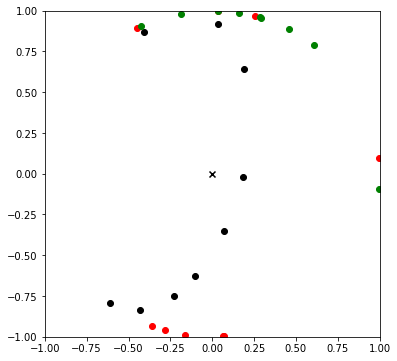

In [50]:
plt.figure(figsize=(6,6))
# plt.scatter(Bhelix((day*deg) * np.pi/180, best_pitch, -1)[0,:],Bhelix((day*deg) * np.pi/180, best_pitch, -1)[1,:], c='b')
# plt.scatter(Y_hat[0,:], Y_hat[1,:], c='g')
plt.scatter(Y_hat_nest[0,:], Y_hat_nest[1,:], c='k')
plt.scatter(np.cos(PA*np.pi/180), np.sin(PA*np.pi/180), c='r')
plt.scatter(np.cos(PA_jet*np.pi/180), np.sin(PA_jet*np.pi/180), c='g')
plt.scatter(0,0,marker='x',c='k')
plt.ylim([-1,1])
plt.xlim([-1,1])

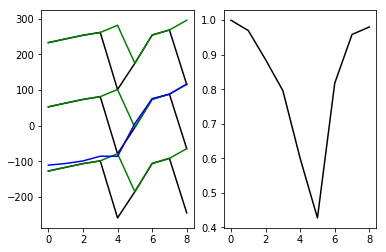

In [57]:
# plt.plot(np.arctan(Y_hat[1,:]/Y_hat[0,:]) * 180/np.pi)
# plt.plot(np.arctan(Y_hat[1,:]/Y_hat[0,:]) * 180/np.pi +180)

plt.subplot(121)
plt.plot(np.arctan(Y_hat_nest[1,:]/Y_hat_nest[0,:]) * 180/np.pi,'k')
plt.plot(np.arctan(Y_hat_nest[1,:]/Y_hat_nest[0,:]) * 180/np.pi+180,'k')
plt.plot(np.arctan(Y_hat_nest[1,:]/Y_hat_nest[0,:]) * 180/np.pi-180,'k')
plt.plot(PA_jet,'g')
plt.plot(PA_jet+180,'g')
plt.plot(PA_jet-180,'g')
plt.plot(PA,'b')

plt.subplot(122)
plt.plot((Y_hat_nest[0,:]**2 + Y_hat_nest[1,:]**2)**((2-1)/4),'k')
#plt.plot(P_jet,'g')
#plt.plot(Flux,'b')

In [63]:
Y_hat_nest[0,:]**2 + Y_hat_nest[1,:]**2

array([0.99849527, 0.88460056, 0.61498429, 0.40118195, 0.12941165,
       0.03339016, 0.4468066 , 0.84399074, 0.92290334])

In [64]:
Y_hat_nest[:,0]

array([-0.61018957, -0.79130522,  0.03879085])

In [47]:
# Define and solve the CVXPY problem.
x = cvx.Variable(6)
t = cvx.Variable()
y = cvx.Variable(44)
day = Day - np.min(Day)
A = [np.array([[B[0],B[1],B[2],0,0,0],
           [0,0,0,B[0],B[1],B[2]]]) for B in Bhelix(day*deg * np.pi/180, 1,sign=-1).T]
A = np.vstack(A)
print(A.shape)
b = [np.array([np.cos(p*np.pi/180),np.sin(p*np.pi/180)]) for p in PA]
b = np.concatenate(b, axis=0)
print(b.shape)

loglike = lambda x: np.linalg.norm(A@x - b)**2 
x0 = (0.8,1.8)
res = minimize(loglike, x0=x0, bounds=((0,1),(0,np.pi)))
print(res['x'][0]), print(res['x'][1] * 180/np.pi)







# prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(A @ x - b)),
#                  [])
# #                   x <= np.ones(6), 
# #                   x >= -np.ones(6), 


# prob.solve()
# # Print result.
# print("\nThe optimal value is", prob.value)
# print("A solution x is")
# print(x.value)
# # print("A dual solution is")
# # print(prob.constraints[0].dual_value)

(44, 6)
(44,)

The optimal value is 0.93820725216106
A solution x is
[-0.84989192 -0.03561087 -0.28225559  0.576853   -1.21054215 -0.23146053]


In [5]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

In [6]:
def QPsolver(data, prediction, lower, upper, bound_vals):
    Flux, Flux_err = data

    m = len(Flux); n = 2 #dimensions
    w = np.diag(1 / Flux_err)
    Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
    Ad = sparse.csc_matrix(Ad)
    b = np.matmul(w, Flux)
    constraint_M = np.array([[bound_vals[0], 1],[bound_vals[1], 1], [1, 0]]) #constrain_M * x < u etc.

    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n+1, m))])], format='csc')
    l = np.hstack([b, lower, lower, 1e-4])
    u = np.hstack([b, upper, upper, np.inf])

    with nostdout():
        # Create an OSQP object
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, Q, A, l, u, eps_rel=1e-7,polish=1)
        # Solve problem
        res = prob.solve()

    return res.x[:2], res.info.obj_val #flux_scale and loss

# PyMultiNest nested sampling to find likelihood function minima

In [2]:
def Rot(phi): 
    return np.array([[math.cos(phi),0,math.sin(phi)],[0,1,0],[-math.sin(phi),0,math.cos(phi)]])
def RotX(phi): 
    return np.array([[1,0,0],[0,math.cos(phi),-math.sin(phi)],[0,math.sin(phi),math.cos(phi)]])
def Bhelix(phase, slope, sign, global_sign=1):
    h = global_sign * np.array([sign * np.cos(phase), np.sin(phase), np.ones_like(phase) * slope])
    return h / np.linalg.norm(h,axis=0)
def flux_weight(angle, alpha):
    """Takes angle of B-field to our line of sight and returns the relative weighted flux"""
    return np.sin(angle)**((alpha + 1)/2)
def get_perp(vector2d):
    return np.array(vector2d[1],-vector2d[0])
def points_on_circumference(center=(0, 0), r=50, n=100):
    return [
        (
            center[0]+(math.cos(2 * pi / n * x) * r),  # x
            center[1] + (math.sin(2 * pi / n * x) * r)  # y
        ) for x in range(0, n )]

D = lambda Gamma, theta: 1 / (Gamma * (1 - np.sqrt(1-1/Gamma**2)*np.cos(np.deg2rad(theta))))
Dapprox = lambda Gamma, ratio: 2 * Gamma / (1 + ratio**2)

def pcircle(R, a, N ):
    """Generate N coordinates on a circle of radius a at r=R,phi=0"""
    circle = np.array(points_on_circumference(center=(R, 0), r=a, n=N))
    r = np.sqrt(circle[:,0]**2 + circle[:,1]**2)
    th = np.arctan2(circle[:,1],circle[:,0])
    return np.array([r,th])

def rotate(th, B, axis): #about arbitrary axis
    #axis[] = axis / np.linalg.norm(axis)
    B1 = (- axis[:,:,0] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,0]*np.cos(th) \
    + (-axis[:,:,2]*B[:,:,1] + axis[:,:,1]*B[:,:,2]) * np.sin(th)
    B2 = (- axis[:,:,1] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,1]*np.cos(th) \
    + (axis[:,:,2]*B[:,:,0] - axis[:,:,0]*B[:,:,2]) * np.sin(th)
    B3 = (- axis[:,:,2] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,2]*np.cos(th) \
    + (-axis[:,:,1]*B[:,:,0] + axis[:,:,0]*B[:,:,1]) * np.sin(th)
    return np.stack([B1,B2,B3],axis=2)

In [254]:
th = 0.0
B = np.array([[[1., 0., 0]]])
axis = np.array([[[0, 1, 0]]])
print(axis, B, th)
rotate(th, B, axis)

[[[0 1 0]]] [[[1. 0. 0.]]] 0.0


array([[[1., 0., 0.]]])

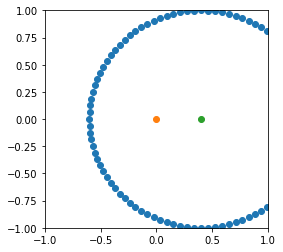

In [107]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
x = np.array(points_on_circumference(center=(0.4, 0), r=1, n=100))
plt.scatter(x[:,0],x[:,1])
plt.scatter(0,0)
plt.scatter(0.4,0)

Saving frame movies2/_tmp000.jpg


/share/software/user/open/py-matplotlib/2.1.2_py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saving frame movies2/_tmp001.jpg
Saving frame movies2/_tmp002.jpg
Saving frame movies2/_tmp003.jpg
Saving frame movies2/_tmp004.jpg
Saving frame movies2/_tmp005.jpg
Saving frame movies2/_tmp006.jpg
Saving frame movies2/_tmp007.jpg
Saving frame movies2/_tmp008.jpg
Saving frame movies2/_tmp009.jpg
Saving frame movies2/_tmp010.jpg
Saving frame movies2/_tmp011.jpg
Saving frame movies2/_tmp012.jpg
Saving frame movies2/_tmp013.jpg
Saving frame movies2/_tmp014.jpg
Saving frame movies2/_tmp015.jpg
Saving frame movies2/_tmp016.jpg
Saving frame movies2/_tmp017.jpg
Saving frame movies2/_tmp018.jpg
Saving frame movies2/_tmp019.jpg
Saving frame movies2/_tmp020.jpg
Saving frame movies2/_tmp021.jpg
Saving frame movies2/_tmp022.jpg
Saving frame movies2/_tmp023.jpg
Saving frame movies2/_tmp024.jpg
Saving frame movies2/_tmp025.jpg
Saving frame movies2/_tmp026.jpg
Saving frame movies2/_tmp027.jpg
Saving frame movies2/_tmp028.jpg
Saving frame movies2/_tmp029.jpg
Saving frame movies2/_tmp030.jpg
Saving fra

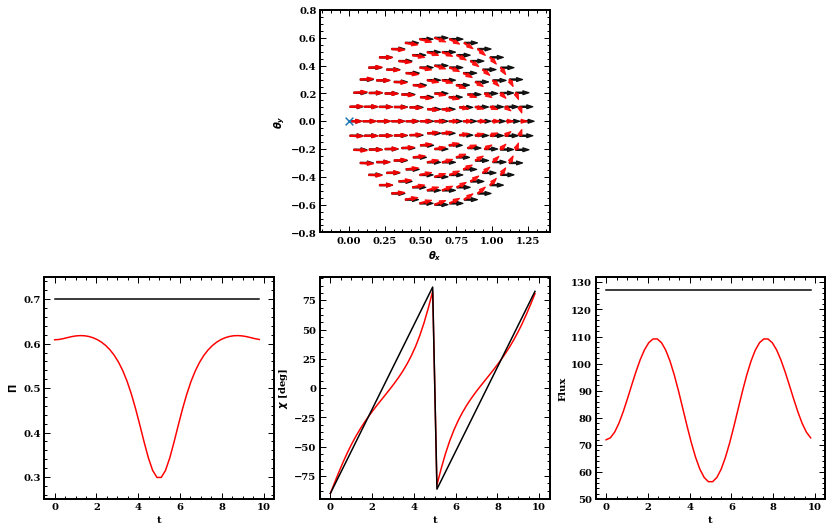

In [4]:
# fig, ax = plt.subplots(figsize=(14,9),nrows=2,ncols=3)
# (ax1,ax2,ax3,ax4,ax5,ax6) = ax.flat
# ax1.remove()
# ax3.remove()

ratio = 0.6
ratio_range = 0.6
pitch = 0.2
B1, B2, coords = Jet(np.linspace(0,10,50), ratio, ratio_range, pitch, 0, deg=36, sign=1, alpha=2, 
                              Gamma=10,global_sign=1,plot=True)
pi_hat, pa_hat, p_hat = Jet(np.linspace(0,10,50), ratio, ratio_range, pitch, 0, deg=36, sign=1, alpha=2, 
                              Gamma=10,global_sign=1,plot=False)
pi_hat1, pa_hat1, p_hat1 = Jet(np.linspace(0,10,50), 0, 0, pitch, 0, deg=36, sign=1, alpha=2, 
                              Gamma=10,global_sign=1,plot=False)

# for i in range(len(coords[0,:])):
#     r = 0.05*np.sqrt(B1[i,idx,0] **2 + B1[i,idx,1]**2)
#     theta = np.arctan2(B1[i,idx,1], B1[i,idx,0])
#     ax2.arrow(coords[0,i]*np.cos(coords[1,i]),coords[0,i]*np.sin(coords[1,i]),
#              r*np.cos(theta), r*np.sin(theta),color="k"
#              ,width=0.01,alpha=0.9)
    
# for i in range(len(coords[0,:])):
#     r = 0.05*np.sqrt(B2[i,idx,0] **2 + B2[i,idx,1]**2)
#     theta = np.arctan2(B2[i,idx,1], B2[i,idx,0])
#     ax2.arrow(coords[0,i]*np.cos(coords[1,i]),coords[0,i]*np.sin(coords[1,i]),
#              r*np.cos(theta), r*np.sin(theta),color="r"
#              ,width=0.01,alpha=0.9)
    

# ax2.scatter([0],[0],marker="x",s=60,zorder=100,color="k")
# ax2.set_xlim(ratio-0.8,ratio + 0.8)
# ax2.set_ylim(-0.8,0.8)
# ax2.set_xlabel(r"$\theta_{x}$")
# ax2.set_ylabel(r"$\theta_{y}$")

# ax4.plot(np.linspace(0,10,50),pi_hat,"r")
# ax4.plot(np.linspace(0,10,50),pi_hat1,"k")
# ax4.set_xlabel("t",fontweight="bold")
# ax4.set_ylabel(r"$\Pi$",fontweight="bold")
# ax5.plot(np.linspace(0,10,50),pa_hat,"r")
# ax5.plot(np.linspace(0,10,50),pa_hat1,"k")
# ax5.set_xlabel("t",fontweight="bold")
# ax5.set_ylabel(r"$\chi$ [deg]",fontweight="bold")
# ax6.plot(np.linspace(0,10,50),p_hat,"r")
# ax6.plot(np.linspace(0,10,50),p_hat1,"k")
# ax6.set_xlabel("t",fontweight="bold")
# ax6.set_ylabel(r"Flux",fontweight="bold")

files = []

#fig,ax = plt.subplots(figsize=(7,7))
fig, ax = plt.subplots(figsize=(14,9),nrows=2,ncols=3)
(ax1,ax2,ax3,ax4,ax5,ax6) = ax.flat
ax1.remove()
ax3.remove()
for idx in range(len(B1[0,:,0])):  # 50 frames
    ax2.cla()
    ax4.cla()
    ax5.cla()
    ax6.cla()
    ax2.set_xlim(ratio-0.8,ratio + 0.8)
    ax2.set_ylim(-0.8,0.8)
    ax2.set_xlabel(r"$\theta_{x}$")
    ax2.set_ylabel(r"$\theta_{y}$")
    ax2.scatter([0],[0],marker="x",s=60,zorder=2)
    
    ax4.plot(np.linspace(0,10,50)[:idx],pi_hat[:idx],"r")
    ax4.plot(np.linspace(0,10,50)[:idx],pi_hat1[:idx],"k")
    ax4.set_xlim(-0.5,10.5)
    ax4.set_ylim(0.25,0.75)
    ax4.set_xlabel("t",fontweight="bold")
    ax4.set_ylabel(r"$\Pi$",fontweight="bold")
    ax5.plot(np.linspace(0,10,50)[:idx],pa_hat[:idx],"r")
    ax5.plot(np.linspace(0,10,50)[:idx],pa_hat1[:idx],"k")
    ax5.set_xlim(-0.5,10.5)
    ax5.set_ylim(-95,95)
    ax5.set_xlabel("t",fontweight="bold")
    ax5.set_ylabel(r"$\chi$ [deg]",fontweight="bold")
    ax6.plot(np.linspace(0,10,50)[:idx],p_hat[:idx],"r")
    ax6.plot(np.linspace(0,10,50)[:idx],p_hat1[:idx],"k")
    ax6.set_xlim(-0.5,10.5)
    ax6.set_ylim(50,132)
    ax6.set_xlabel("t",fontweight="bold")
    ax6.set_ylabel(r"Flux",fontweight="bold")
    
    for i in range(len(coords[0,:])):
        r = 0.05*np.sqrt(B1[i,idx,0] **2 + B1[i,idx,1]**2)
        theta = np.arctan2(B1[i,idx,1], B1[i,idx,0])
        ax2.arrow(coords[0,i]*np.cos(coords[1,i]),coords[0,i]*np.sin(coords[1,i]),
                 r*np.cos(theta), r*np.sin(theta),color="k"
                 ,width=0.01,alpha=0.9)
    for i in range(len(coords[0,:])):
        r = 0.05*np.sqrt(B2[i,idx,0] **2 + B2[i,idx,1]**2)
        theta = np.arctan2(B2[i,idx,1], B2[i,idx,0])
        ax2.arrow(coords[0,i]*np.cos(coords[1,i]),coords[0,i]*np.sin(coords[1,i]),
                 r*np.cos(theta), r*np.sin(theta),color="r"
                 ,width=0.01,alpha=0.9)
    
    fname = 'movies2/_tmp{0:0=3d}.jpg'.format(idx)
    print('Saving frame', fname)
    plt.savefig(fname)
    files.append(fname)


In [3]:
def Jet(day, ratio, ratio_range, pitch, offset, deg, axis=0, sign=-1, alpha=2, Gamma=10, global_sign=1,plot=False):
    """Helical jet of jets
    
    Args:
        day: 
        ratio: Gamma*theta of the jet centre.
        ratio_range: Opening angle of the jet.
        pitch: Magnetic Helix pitch angle.
        offset: In degrees. (NOT a 'physical' parameter)
        deg: Conversion from day to degrees. (NOT a 'physical' parameter)
        alpha: electron power law.
      
    Returns:
        Pi:
        PA:
        P:
    
    Raises:
        ValueError: Opening angle of jet too large.
    """
    if ratio_range > 1:
        raise ValueError("Jet opening angle can't be greater than 1/Gamma in Lab frame")
        
    day = day - np.min(day)
    B_orig = Bhelix((day*deg + offset) * np.pi/180, pitch, sign, global_sign)
    #Build jet of jets in multiple circles:
    coords = np.concatenate([pcircle(ratio, ratio_range, 36),pcircle(ratio, 5*ratio_range/6, 30), 
                             pcircle(ratio, 4*ratio_range/6, 24), pcircle(ratio, 3*ratio_range/6, 18),
                             pcircle(ratio, 2*ratio_range/6, 12), pcircle(ratio, 1*ratio_range/6, 6),
                         pcircle(ratio, 0*ratio_range/6, 1)],axis=1)
    
    theta_rot = np.arccos((1 - coords[0,:]**2) / (1 + coords[0,:]**2))
    x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
    x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
    x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
    _, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)
    B_mesh = np.stack([x0,x1,x2],axis=2)
    axis_mesh = np.stack([y0,y1,y2],axis=2)
    
    B = rotate(th, B_mesh, axis_mesh)
    #B shape = (coords,days,3)
    
    Btheta = np.arctan2(np.sqrt(np.sum(B[:,:,:2]**2,axis=2)), B[:,:,2])
    weights = (D(Gamma,coords[0,:]/Gamma)**4 * flux_weight(Btheta, alpha).T).T #broadcast
    weights = weights / np.max(weights)
    
    vec = copy.copy(B[:,:,:2][:,:,::-1])
    vec[:,:,1] *= -1
    PA = np.arctan2(vec[:,:,1],vec[:,:,0])
    S1 = np.sum(weights * np.cos(2 * PA),axis=0)
    S2 = np.sum(weights * np.sin(2 * PA),axis=0)
    Pi = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / np.sum(weights,axis=0)
    PA = np.rad2deg(np.arctan2(S2,S1) / 2 ) + axis
    P = np.sum(weights, axis=0)
    
    if plot:
        return B_mesh, B, coords
    else:
        return Pi, PA, P

    


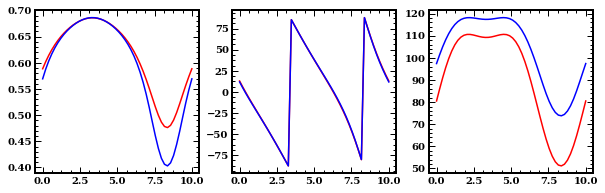

In [23]:
pi_hat, pa_hat1, p_hat1 = Jet(np.linspace(0,10,50), 0.3, 0.4, 0.5, 60, deg=36, sign=-1, alpha=3, Gamma=5,global_sign=1)
pi_hat2, pa_hat2, p_hat2 = Jet(np.linspace(0,10,50), 0.3, 0.4, 0.5, 60, deg=36, sign=-1, alpha=1, Gamma=5,global_sign=1)


fig,(ax1,ax2,ax3) = plt.subplots(figsize=(10,3),ncols=3)
ax1.plot(np.linspace(0,10,50),pi_hat,"r")
ax2.plot(np.linspace(0,10,50),pa_hat1,"r")
ax3.plot(np.linspace(0,10,50),p_hat1,"r")

ax1.plot(np.linspace(0,10,50),pi_hat2,"b")
ax2.plot(np.linspace(0,10,50),pa_hat2,"b")
ax3.plot(np.linspace(0,10,50),p_hat2,"b")



In [44]:
def QPsolver(data, prediction):
    Flux, Flux_err = data

    m = len(Flux); n = 2 #dimensions
    w = np.diag(1 / Flux_err)
    Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
    Ad = sparse.csc_matrix(Ad)
    b = np.matmul(w, Flux)
    constraint_M = np.array([[1,0],[0,1]]) #constrain_M * x < u etc.

    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    l = np.hstack([b, 1e-6, 1e-6, ])
    u = np.hstack([b, np.inf, np.inf, ])


    # Create an OSQP object
    prob = osqp.OSQP()
    # Setup workspace
    prob.setup(P, Q, A, l, u, eps_rel=1e-4,polish=1)
    # Solve problem
    res = prob.solve()

    return res.x[:2], res.info.obj_val #flux_scale and loss

[0.49 0.48 0.53 0.44 0.42 0.45]
[0.03 0.01 0.01 0.01 0.01 0.02]
[ 71.21789985  53.16638196  86.54803052 101.11614696 114.69993952
 123.54606753]


ValueError: x and y must have same first dimension, but have shapes (100,) and (6,)

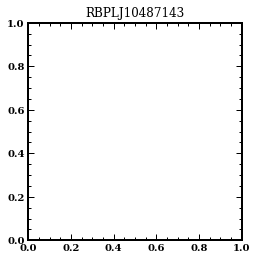

In [48]:
blazars = ['RBPLJ01364751.dat',
'RBPLJ08542006.dat',
'RBPLJ10487143.dat',
'RBPLJ15585625.dat',
'RBPLJ17510939_1.dat',
'RBPLJ17510939_2.dat',
'RBPLJ18066949.dat',
'RBPLJ18092041.dat',
'RBPLJ22321143.dat',
'RBPLJ23113425.dat']
data = []
for blazar in blazars:
    data.append(np.loadtxt("/home/groups/rwr/alpv95/SAVRot/data/" + blazar))

measured = pd.read_csv("/home/groups/rwr/alpv95/SAVRot/data/sample.txt")

datum = data[0]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))
x = np.linspace(Day[0],Day[-1],100)
print(Flux)
print(Flux_err)

pi_hat, pa_hat1, p_hat1 = Jet(Day, 1.7309335470199585, 0.6575479507446289,
                              -1.8863520622253418, 137.11280822753906, 
                              deg=6.5852340535120355, sign=1, alpha=2, Gamma=10,global_sign=1)
print(p_hat1)
pi_hat, pa_hat2, p_hat2 = Jet(Day, 0.5, 0.1, 2.0, 360, deg=deg, sign=-1, alpha=2, Gamma=10,global_sign=1)

plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1  ) 
plt.title(blazars[2].replace(".dat",""))
plt.plot(x,pi_hat)
plt.ylabel(r"$\Pi$")
plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')

plt.subplot(1,3, 2)
plt.ylabel(r"$\theta_{PA}$")
#plt.ylim(min(PA) - 20, max(PA) + 20)
plt.plot(x,pa_hat1)
plt.plot(x,pa_hat2)
plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')

plt.subplot(1,3, 3)
plt.ylabel(r"$Flux$")
plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')
#plt.plot(x, p_hat1)
#plt.plot(x, p_hat2)

In [46]:
x, loss_flux = QPsolver((Flux, Flux_err), p_hat1,)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 8, constraints m = 8
          nnz(P) + nnz(A) = 26
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   5.30e+01   4.24e+04   1.00e-01   1.48e-04s
  50   2.8519e+01   3.89e-03   6.99e-04   8.63e-01   3.16e-04s
plsh   2.8545e+01   3.41e-09   2.99e-12   -------- 

In [42]:
loss_flux

28.544676983583177

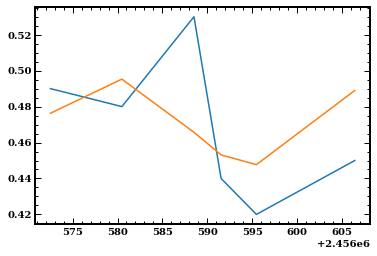

In [43]:
plt.plot(Day,Flux)
plt.plot(Day,x[0]*p_hat1 + x[1])

In [ ]:
def main(datafile, delta, resume, data_idx, sign=1):
    print(sign)
    blazars = ['RBPLJ01364751.dat',
    'RBPLJ08542006.dat',
    'RBPLJ10487143.dat',
    'RBPLJ15585625.dat',
    'RBPLJ17510939_1.dat',
    'RBPLJ17510939_2.dat',
    'RBPLJ18066949.dat',
    'RBPLJ18092041.dat',
    'RBPLJ22321143.dat',
    'RBPLJ23113425.dat']
    data = []
    for blazar in blazars:
        data.append(np.loadtxt("/home/groups/rwr/alpv95/SAVRot/data/" + blazar))

    #measured = pd.read_csv("/home/groups/rwr/alpv95/SAVRot/data/sample.txt")

    datum = data[data_idx]
    Day = datum[:,0]
    Flux = datum[:,5]; Flux_err = datum[:,6]
    PA = datum[:,3]; PA_err = datum[:,4]
    Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
    deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

    def prior(cube, ndim, nparams):
        #ratio, ratio_range, pitch, offset, sign, deg = X
        cube[0] *= 2 #ratio
        #ratio range just between 0 - 1
        cube[2] = cube[1]*10 #pitch
        cube[3] = cube[2]*720 - 360 #offset
#         cube[4] = cube[4] * (-deg*0.85 + deg*1.15) + deg*0.85 #deg
        return cube

    def loglike(cube, ndim, nparams):
        #ratio, ratio_range, pitch, offset, deg = cube[0],cube[1],cube[2],cube[3],cube[4]
        ratio, ratio_range, pitch, offset = cube[0], cube[1], cube[2], cube[3]
        pi_hat, pa_hat, p_hat = Jet(Day, ratio, 0, pitch=pitch, offset=offset, deg=deg, sign=sign, alpha=2, Gamma=10)
        #Do linear regression to find optimal axis value here
        b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
        A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                            [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)
        
        w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
        w = np.diag(1 / w) #weighted least squares
        _, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))        
        _, loss_flux = QPsolver((Flux, Flux_err), p_hat, 0, np.inf, bound_vals=(np.max(p_hat),np.min(p_hat),np.inf))
        _, loss_pi = QPsolver((Pi, Pi_err), pi_hat, 0, 0.8, bound_vals=(np.max(pi_hat),np.min(pi_hat),0.05))
                
        return -(delta[0] * loss_pa[0] + delta[1] * loss_flux + delta[2] * loss_pi)


    # analyse the file given as first argument
    try: os.mkdir(datafile)
    except OSError: pass
    datafile = datafile + "/3-"

    # number of dimensions our problem has
    parameters = ["ratio", "ratio_range", "pitch", "offset"]
    #parameters = ["ratio","pitch","offset"]
    n_params = len(parameters)

    # run MultiNest
    pymultinest.run(loglike, prior, n_params, outputfiles_basename=datafile + '_1_', resume = resume, verbose = True, 
                    const_efficiency_mode=True, n_live_points=1000, evidence_tolerance=0.5, sampling_efficiency=0.9,)
    json.dump(parameters, open(datafile + '_1_params.json', 'w')) # save parameter names

    a = pymultinest.Analyzer(outputfiles_basename=datafile + '_1_', n_params = n_params)
    print(a.get_best_fit())

    '''---------------- Print Parameters and their associated errors ------------------ '''
    s = a.get_stats()
    print('  marginal likelihood:')
    print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
    print('  parameters:')
    for p, m in zip(parameters, s['marginals']):
        lo, hi = m['1sigma']
        med = m['median']
        sigma = (hi - lo) / 2
        if sigma == 0:
                i = 3
        else:
                i = max(0, int(-np.floor(np.log10(sigma))) + 1)
        fmt = '%%.%df' % i
        fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
        print(fmts % (p, med, sigma))

    '''----------------  Corner Plot  ------------------ '''
    print('creating marginal plot ...')
    data = a.get_data()[:,2:]
    weights = a.get_data()[:,0]
    #mask = weights.cumsum() > 1e-5
    for thresh in [1e-4,7e-5,4e-5,1e-5,1e-6]:
        try:
            mask = weights > thresh
            corner.corner(data[mask,:], weights=weights[mask],
                labels=parameters, show_titles=True, title_fmt=".2f",)
            break
        except:
            continue

main(datafile="TEST_init", delta=[1,0.01,0.01], resume=False, data_idx=2, sign=1)


1


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [24]:
posterior = np.loadtxt("TEST_init/3-_1_.txt")

In [31]:
posterior[:,1].argsort()

array([2278, 2205, 2290, ...,    2,    1,    0])

In [35]:
posterior[2205,:]

array([4.60804146e-04, 1.14779707e-01, 4.79943965e-01, 5.29858727e-01,
       8.27149199e+01])

In [30]:
x = np.array([[1,4],[3,6],[5,1]])
np.ndarray.sort(x, axis=0)
print(x)

[[1 1]
 [3 4]
 [5 6]]


In [9]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def QPsolver(data, prediction):
    Flux, Flux_err = data

    m = len(Flux); n = 2 #dimensions
    w = np.diag(1 / Flux_err)
    Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
    Ad = sparse.csc_matrix(Ad)
    b = np.matmul(w, Flux)
    constraint_M = np.array([[1,0],[0,1]]) #constrain_M * x < u etc.

    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    l = np.hstack([b, 1e-6, 1e-6, ])
    u = np.hstack([b, np.inf, np.inf, ])

    with nostdout():
        # Create an OSQP object
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, Q, A, l, u, eps_rel=1e-4,polish=1)
        # Solve problem
        res = prob.solve()

    return res.x[:2], res.info.obj_val #flux_scale and loss

In [26]:
blazars = ['RBPLJ01364751.dat',
'RBPLJ08542006.dat',
'RBPLJ10487143.dat',
'RBPLJ15585625.dat',
'RBPLJ17510939_1.dat',
'RBPLJ17510939_2.dat',
'RBPLJ18066949.dat',
'RBPLJ18092041.dat',
'RBPLJ22321143.dat',
'RBPLJ23113425.dat']

In [220]:
idx = 9
blazar = blazars[idx].replace(".dat","")
helicity = -1

datum = np.loadtxt("/home/groups/rwr/alpv95/SAVRot/data/" + blazar + ".dat")              
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100

with open('/home/users/alpv95/khome/SAVRot/TALK2/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/TALK2/3-_1_"+str(helicity) + blazar, n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']

5
  analysing data from /home/users/alpv95/khome/SAVRot/TALK2/3-_1_-1RBPLJ23113425.txt
{'log_likelihood': -1820.8654250415575, 'parameters': [1.244407848722316, 0.3961184329929928, 0.21777601812493863, -91.63014250257572, 4.124919525362847]}


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and 

Text(0.5,1,'RBPLJ23113425')

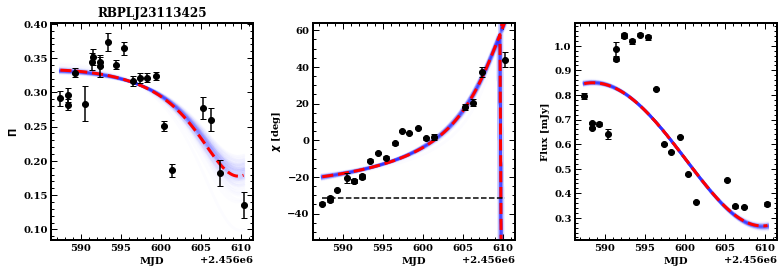

In [221]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(13,4),ncols=3,gridspec_kw={"wspace": 0.3})
x = np.linspace(Day[0],Day[-1],100)
trans = 0.01

for (ratio, ratio_range, pitch, offset, deg) in a.get_equal_weighted_posterior()[::100, :-1]:    
    pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=helicity, alpha=2, Gamma=10)
    
    b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
    A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                        [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)  
    w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
    w = np.diag(1 / w) #weighted least squares
    X, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    axis = np.arctan2(X[1],X[0]) / 2
    
    flux_scale, _ = QPsolver((Flux, Flux_err), p_hat,)
    
    A = np.array([pi_hat]).T
    w = np.diag(1 / Pi_err)
    b = Pi
    pi_scale, _, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
       
    pi_hat, pa_hat, p_hat = Jet(x, ratio, ratio_range, pitch, offset, deg=deg, sign=helicity, axis=np.rad2deg(axis), alpha=2, Gamma=10)
    
    
    ax1.plot(x,pi_hat * pi_scale[0],'b',linewidth=3, alpha=trans)
    
    ax2.plot(x,pa_hat,'b',linewidth=3, alpha=trans)
    ax2.plot(x,pa_hat-180,'b',linewidth=3, alpha=trans)
    ax2.plot(x,pa_hat+180,'b',linewidth=3, alpha=trans)
    ax2.plot(x,pa_hat-360,'b',linewidth=3, alpha=trans)
    ax2.plot(x,pa_hat+360,'b',linewidth=3, alpha=trans)
#     plt.plot(x,pa_hat-540,'b',linewidth=3, alpha=0.05)
#     plt.plot(x,pa_hat+540,'b',linewidth=3, alpha=0.05)
    
    ax3.plot(x, p_hat * flux_scale[0] + flux_scale[1],'b',linewidth=3, alpha=trans)
    
(ratio, ratio_range, pitch, offset, deg) = result
pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=helicity, alpha=2, Gamma=10)
b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                    [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)  
w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
w = np.diag(1 / w) #weighted least squares
X, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
axis = np.arctan2(X[1],X[0]) / 2

flux_scale, _ = QPsolver((Flux, Flux_err), p_hat,)

A = np.array([pi_hat]).T
w = np.diag(1 / Pi_err)
b = Pi
pi_scale, _, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))

pi_hat, pa_hat, p_hat = Jet(x, ratio, ratio_range, pitch, offset, deg=deg, sign=helicity, axis=np.rad2deg(axis), alpha=2, Gamma=10)

ax1.plot(x,pi_hat * pi_scale[0],'r--',linewidth=3)
ax2.plot(x,pa_hat,'r--',linewidth=3, alpha=1)
ax2.plot(x,pa_hat-180,'r--',linewidth=3, alpha=1)
ax2.plot(x,pa_hat+180,'r--',linewidth=3, alpha=1)
ax2.plot(x,pa_hat-360,'r--',linewidth=3, alpha=1)
ax2.plot(x,pa_hat+360,'r--',linewidth=3, alpha=1)
ax2.plot([min(Day),max(Day)],[np.rad2deg(axis),np.rad2deg(axis)],"k--")
ax2.plot([min(Day),max(Day)],[np.rad2deg(axis)+180,np.rad2deg(axis)+180],"k--")
ax3.plot(x, p_hat * flux_scale[0] + flux_scale[1],'r--',linewidth=3,)

ax1.set_ylabel(r"$\Pi$")
ax2.set_ylabel(r"$\chi$ [deg]",fontweight="bold")
ax3.set_ylabel(r"Flux [mJy]",fontweight="bold")
ax1.set_xlabel("MJD",fontweight="bold")
ax2.set_xlabel("MJD",fontweight="bold")
ax3.set_xlabel("MJD",fontweight="bold")
ax2.set_ylim(min(PA) - 20, max(PA) + 20)
ax2.errorbar(Day,PA,yerr=PA_err,c='k',fmt='o',zorder=100)
ax3.errorbar(Day,Flux,yerr=Flux_err,c='k',fmt='o',zorder=100)
ax1.errorbar(Day,Pi,yerr=Pi_err,c='k',fmt='o',zorder=100)
ax1.set_title(blazar,fontweight="bold")



In [ ]:
for idx in posterior[:,1].argsort()[:50]:
    x0 = posterior[idx,2:]
plt.figure(5)
    plt.hist(x0[0], density=True)

In [ ]:
pi_hat, pa_hat, p_hat = Jet(x, x0[0], 0, pitch=0, offset=x[1], deg=deg, sign=-1, axis=np.rad2deg(axis), alpha=2, Gamma=10)
plt.ylabel(r"$\theta_{PA}$")
Print
plt.plot(x,pa_hat,'b',alpha=0.3)
plt.plot(x,pa_hat-180,'b',alpha=0.3)
plt.plot(x,pa_hat+180,'b',alpha=0.3)

In [7]:
with open('/home/users/alpv95/khome/SAVRot/TEST/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/SAVRot/TEST/3-" + '_1_', n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']

5
  analysing data from /home/users/alpv95/khome/SAVRot/TEST/3-_1_.txt
{'log_likelihood': -2.3053390484889733, 'parameters': [1.8015254268612122, 0.4134484718478842, 0.0825296242806321, 25.181498202278817, 8.4444031166339]}


creating marginal plot ...


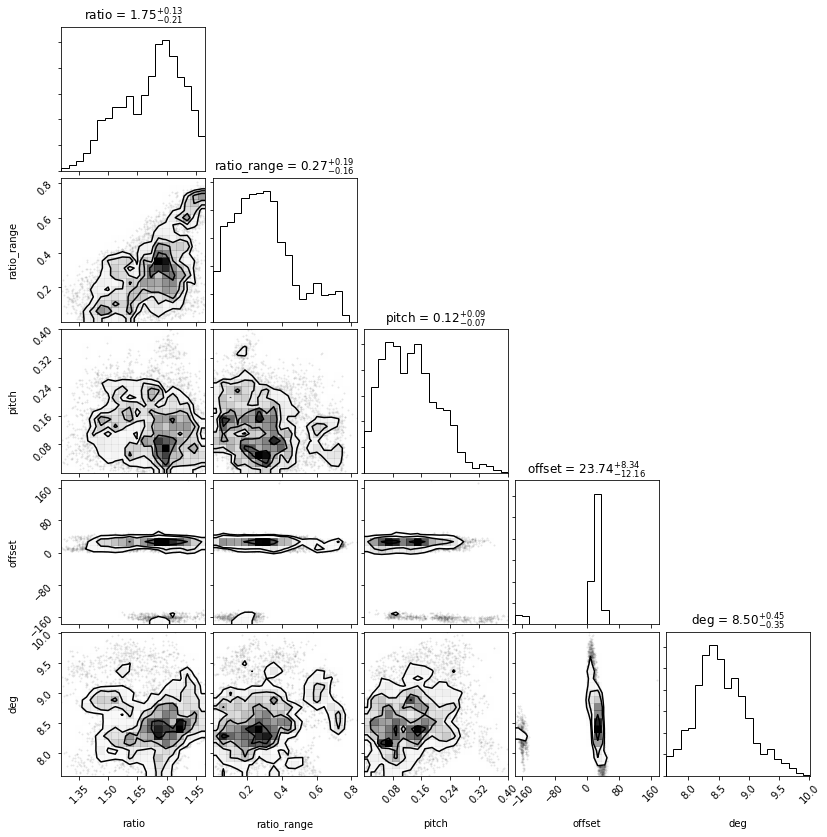

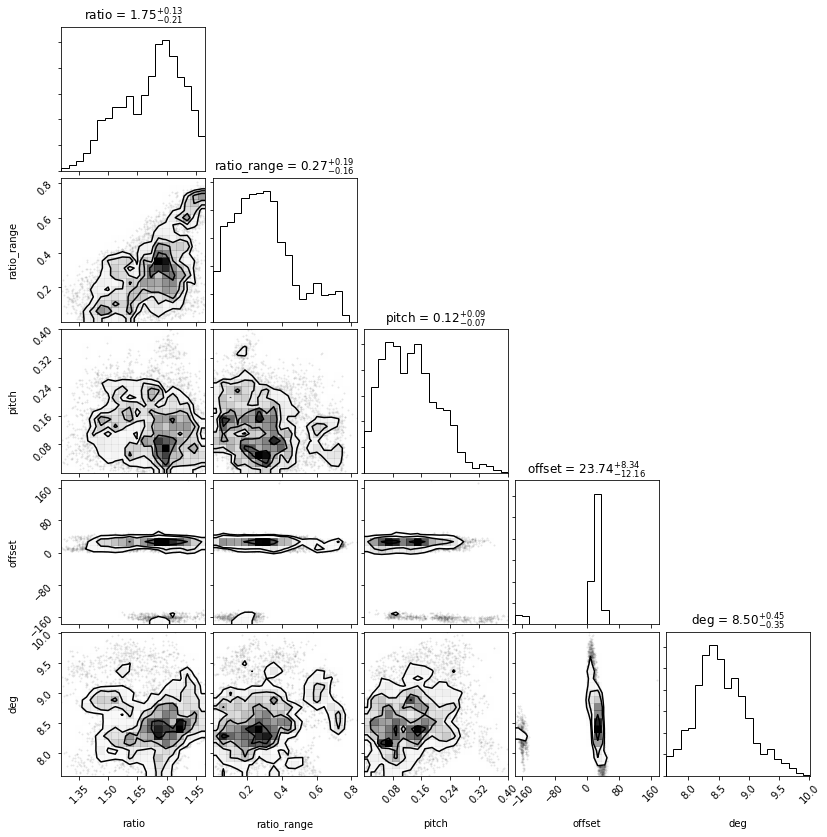

In [8]:
print('creating marginal plot ...')
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]
#mask = weights.cumsum() > 1e-5
mask = weights > 6e-5
corner.corner(data[mask,:], weights=weights[mask],
labels=parameters, show_titles=True, title_fmt=".2f",)

In [54]:
Z = np.concatenate([a.get_equal_weighted_posterior()[::100, :-1],linear_params],axis=1)

In [63]:
np.cov(Z.T)[5:6,:]


array([[-1.34201911e-03,  4.71119228e-02, -1.30234629e-01,
        -4.25998043e+00,  7.05398193e-02,  1.88544680e+00,
        -2.94075892e-07, -1.69192637e-01,  2.01864613e-01,
        -1.34012083e-01]])

creating fit plot ...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


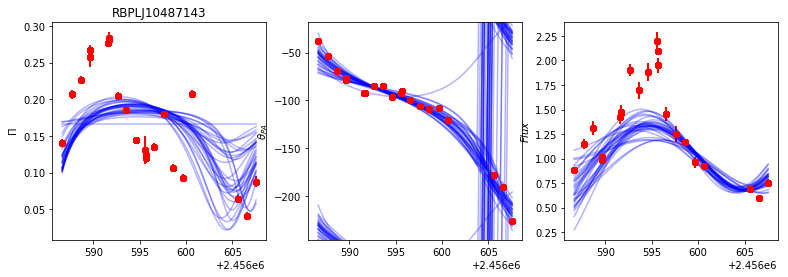

In [14]:
data_idx=2
blazars = ['RBPLJ01364751.dat',
'RBPLJ08542006.dat',
'RBPLJ10487143.dat',
'RBPLJ15585625.dat',
'RBPLJ17510939_1.dat',
'RBPLJ17510939_2.dat',
'RBPLJ18066949.dat',
'RBPLJ18092041.dat',
'RBPLJ22321143.dat',
'RBPLJ23113425.dat']
data = []
for blazar in blazars:
    data.append(np.loadtxt("/home/groups/rwr/alpv95/SAVRot/data/" + blazar))

measured = pd.read_csv("/home/groups/rwr/alpv95/SAVRot/data/sample.txt")

datum = data[data_idx]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

### Define offsets for plotting purposes:
print('creating fit plot ...')
plt.figure(figsize=(13,4))

for x0 in a.get_equal_weighted_posterior()[::200, :-1]:
    x = np.linspace(Day[0],Day[-1],100)
    pi_hat, pa_hat, p_hat = Jet(Day, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=1, alpha=2, Gamma=10)
    
    b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
    A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                        [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)     
    w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
    w = np.diag(1 / w) #weighted least squares
    X, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    axis = np.arctan2(X[1],X[0]) / 2
    
    flux_scale, _ = QPsolver((Flux, Flux_err), p_hat, 0, np.inf,bound_vals=(np.max(p_hat),np.min(p_hat)) )    
    pi_scale, _ = QPsolver((Pi, Pi_err), pi_hat, 0.0, 0.8,bound_vals=(np.max(pi_hat),np.min(pi_hat)))
    
    pi_hat, pa_hat, p_hat = Jet(x, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=1, axis=np.rad2deg(axis), alpha=2, Gamma=10)
    
    plt.subplot(1, 3, 1  ) 
    plt.title(blazars[data_idx].replace(".dat",""))
    plt.ylabel(r"$\Pi$")
    plt.plot(x,pi_hat * pi_scale[0] + pi_scale[1],'b',alpha=0.3)
    plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')
    
    plt.subplot(1,3, 2)
    plt.ylabel(r"$\theta_{PA}$")
    plt.plot(x,pa_hat,'b',alpha=0.3)
    plt.plot(x,pa_hat-180,'b',alpha=0.3)
    plt.plot(x,pa_hat+180,'b',alpha=0.3)
    plt.plot(x,pa_hat-360,'b',alpha=0.3)
    plt.plot(x,pa_hat+360,'b',alpha=0.3)
    plt.plot(x,pa_hat-540,'b',alpha=0.3)
    plt.plot(x,pa_hat+540,'b',alpha=0.3)
    plt.ylim(min(PA) - 20, max(PA) + 20)
    plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')
    
    plt.subplot(1,3, 3)
    plt.ylabel(r"$Flux$")
    plt.plot(x, p_hat * flux_scale[0] + flux_scale[1],'b',alpha=0.3)
    plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')

Superposition of two helixes?

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<ErrorbarContainer object of 3 artists>

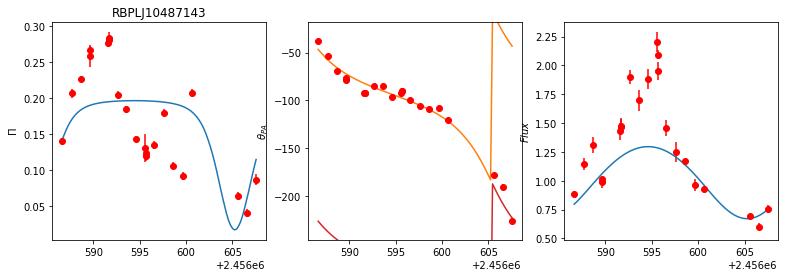

In [24]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001

datum = data[2]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

i=2
plt.figure(figsize=(13,4))
x0 = list(result)
x = np.linspace(Day[0],Day[-1],100)
pi_hat, pa_hat, p_hat = Jet(Day, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=-1, alpha=2, Gamma=10)

b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                    [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)

w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
w = np.diag(1 / w) #weighted least squares
X, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
axis = np.arctan2(X[1],X[0]) / 2
#loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
              #+ abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )

A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
w = np.diag(1 / Flux_err)
b = Flux
flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))

A = np.concatenate([np.array([[pi,1]]) for pi in pi_hat],axis=0)
w = np.diag(1 / Pi_err)
b = Pi
res = lsq_linear(np.matmul(w,A), np.matmul(w,b), bounds=[(0.99,-np.inf),(1.01, np.inf)])
pi_offset = res['x'][1]


pi_hat, pa_hat, p_hat = Jet(x, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[4], sign=-1, axis=np.rad2deg(axis), alpha=2, Gamma=10)

plt.subplot(1, 3, 1  ) 
plt.title(blazars[i].replace(".dat",""))
plt.ylabel(r"$\Pi$")
plt.plot(x,pi_hat + pi_offset)
plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')

plt.subplot(1,3, 2)
# try:
#     plt.title("Axis: {:.1f}, {:.1f}".format(float(measured.loc[:,' PA'][i]),x0[6]))
# except: #ValueError:
#     plt.title("Axis: None, {:.1f}".format(x0[5]))
plt.ylabel(r"$\theta_{PA}$")
plt.plot(x,pa_hat)
plt.plot(x,pa_hat-180)
plt.plot(x,pa_hat+180)
plt.plot(x,pa_hat-360)
plt.plot(x,pa_hat+360)
plt.plot(x,pa_hat-540)
plt.plot(x,pa_hat+540)
plt.ylim(min(PA) - 20, max(PA) + 20)
plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')

plt.subplot(1,3, 3)
# try:
#     plt.title(r"$\Gamma\theta$: {:.1f}, {:.1f}".format(float(measured.loc[:,' gamma'][i]) * 
#                                       np.deg2rad(float(measured.loc[:,' theta'][i])) , x0[0]))
# except:
#     plt.title("$\Gamma\theta$: None, {:.1f}".format(x0[0]))
plt.ylabel(r"$Flux$")
plt.plot(x, p_hat * flux_scale[0] + flux_scale[1])
plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')

In [26]:
print(r"$\Gamma\theta$: {:.2f}".format(1.2344566433))

$\Gamma\theta$: 1.23


In [50]:
#plt.figure() 
a = Analyzer(outputfiles_basename=prefix, n_params = n_params)
# for (pos1, width, height1) in a.get_equal_weighted_posterior()[::100,:-1]:
# 	plt.plot(x, model(pos1, width, height1, 0), '-', color='blue', alpha=0.3, label='data')

  analysing data from chains/3-.txt


In [29]:
result = a.get_equal_weighted_posterior()[:,:-1]

In [51]:
a.get_equal_weighted_posterior()

array([[ 5.28220892e-01,  7.06326365e-02, -3.66515017e+00,
        -1.19926264e+02,  8.65406719e+00,  5.17180538e+01,
         7.95955305e-06,  9.42347050e+01,  2.12882251e-01,
         5.79558795e+06]])

In [30]:
loglike(prior(np.random.uniform(0,1,9),5,1),5,1)

-2662783.7119302256

In [7]:
x = np.linspace(0, 1, 400)
ydata = np.random.uniform(0,5,400) # loaded below

noise = 0.1

delta = 1.0
delta1 = 0.001
delta2 = 0.001

datum = data[2]
Day = datum[:,0]
Flux = datum[:,5]; Flux_err = datum[:,6]
PA = datum[:,3]; PA_err = datum[:,4]
Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

# model for 2 gaussians, same width, fixed offset
def model(pos1, width, height1, height2):
	pos2 = pos1 + 0.05
	return  height1 * stats.norm.pdf(x, pos1, width) + \
		height2 * stats.norm.pdf(x, pos2, width)

# a more elaborate prior
# parameters are pos1, width, height1, [height2]
def prior(cube, ndim, nparams):
    #ratio, ratio_range, pitch, offset, sign, deg = X
    cube[0] *= 2 #ratio
    cube[2] = cube[2]*8 - 4 #pitch
    cube[3] = cube[3]*360 - 180 #offset
    cube[4] = cube[4] * (-deg*0.9 + deg*1.1) + deg*0.9 #deg
    cube[5] = cube[5] * 180 #axis
    cube[6] = 10**(cube[6]*2 - 7)  #flux_scale
    cube[7] = cube[7] * 200 - 100 #flux_offset
    cube[8] = cube[8] * 0.7 #pi_offset
    return cube


def loglike(cube, ndim, nparams):
    ratio, ratio_range, pitch, offset, deg, axis, flux_scale, flux_offset, pi_offset = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7], cube[8]
    pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, axis=axis, sign=-1, alpha=2, Gamma=10)
    
    loss_pa = np.sum( (np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat)))**2 / PA_err**2
                      + (np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat)))**2 / PA_err**2 )
    loss_flux = np.sum( (Flux - (p_hat * flux_scale + flux_offset) )**2 / Flux_err**2 )
    loss_pi = np.sum((Pi - (pi_hat - pi_offset) )**2 / Pi_err**2)
    return -(delta * loss_pa + delta1 * loss_flux + delta2 * loss_pi) 

# analyse the file given as first argument
datafile = "TEST"

# analyse with 1 gaussian

# number of dimensions our problem has
parameters = ["ratio", "ratio_range", "pitch", "offset", "deg", "axis", "flux_scale", "flux_offset", "pi_offset"]
n_params = len(parameters)

# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename=datafile + '_1_', resume = False, verbose = True, 
                const_efficiency_mode=True, n_live_points=600, evidence_tolerance=1.0, sampling_efficiency=0.8,
               init_MPI=True)
json.dump(parameters, open(datafile + '_1_params.json', 'w')) # save parameter names

# plot the distribution of a posteriori possible models
#plt.figure() 
#plt.plot(x, ydata, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename=datafile + '_1_', n_params = n_params)
# for (pos1, width, height1) in a.get_equal_weighted_posterior()[::100,:-1]:
# 	plt.plot(x, model(pos1, width, height1, 0), '-', color='blue', alpha=0.3, label='data')

  analysing data from TEST_1_.txt


In [11]:
filename = "/home/users/alpv95/khome/Rotations/chains/3-"
a = pymultinest.Analyzer(outputfiles_basename=filename + '_1_', n_params = 5)

  analysing data from /home/users/alpv95/khome/Rotations/chains/3-_1_.txt


In [12]:
len(a.get_equal_weighted_posterior())

8828

In [13]:
a.get_best_fit()

{u'log_likelihood': -4.1724167484727595,
 u'parameters': [1.3676079106466434,
  0.8295662830015478,
  -0.011784336136741125,
  22.41766293722361,
  8.444386129542318]}

In [13]:
result = a.get_equal_weighted_posterior()[0,:]
print(result)

[ 1.33603883e+00  8.21276177e-01 -2.45785136e+00 -5.98518693e+01
  8.87235323e+00  1.36550487e+01  6.88961295e-07  2.74081651e-02
  4.77461254e-01 -1.97544717e+01]


In [14]:
result = a.get_best_fit()['parameters']

In [25]:
print(np.rad2deg(axis))

85.5928059718673


In [2]:
def Rot(phi): 
    return np.array([[math.cos(phi),0,math.sin(phi)],[0,1,0],[-math.sin(phi),0,math.cos(phi)]])
def RotX(phi): 
    return np.array([[1,0,0],[0,math.cos(phi),-math.sin(phi)],[0,math.sin(phi),math.cos(phi)]])
def Bhelix(phase, slope, sign):
    h = np.array([sign * np.cos(phase), np.sin(phase), np.ones_like(phase) * slope])
    return h / np.linalg.norm(h,axis=0)
def flux_weight(angle, alpha):
    """Takes angle of B-field to our line of sight and returns the relative weighted flux"""
    return np.sin(angle)**((alpha + 1)/2)
def get_perp(vector2d):
    return np.array(vector2d[1],-vector2d[0])

D = lambda Gamma, theta: 1 / (Gamma * (1 - np.sqrt(1-1/Gamma**2)*np.cos(np.deg2rad(theta))))
Dapprox = lambda Gamma, ratio: 2 * Gamma / (1 + ratio**2)

In [3]:
def pcircle(R, a, N ):
    """Generate N coordinates on a circle of radius a at r=R,phi=0"""
    theta = np.linspace(-np.arctan2(a,R),np.arctan2(a,R), int(N/2))
    r_pos = R*np.cos(theta) + np.sqrt(a**2 - R**2 * np.sin(theta)**2)
    r_min = R*np.cos(theta) - np.sqrt(a**2 - R**2 * np.sin(theta)**2)
    r = np.concatenate([r_pos,r_min])
    th = np.concatenate([theta,theta])
    return np.array([r,th])

In [4]:
def rotate(th, B, axis): #about arbitrary axis
    #axis[] = axis / np.linalg.norm(axis)
    B1 = (- axis[:,:,0] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,0]*np.cos(th) \
    + (-axis[:,:,2]*B[:,:,1] + axis[:,:,1]*B[:,:,2]) * np.sin(th)
    B2 = (- axis[:,:,1] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,1]*np.cos(th) \
    + (axis[:,:,2]*B[:,:,0] - axis[:,:,0]*B[:,:,2]) * np.sin(th)
    B3 = (- axis[:,:,2] * (-axis[:,:,0]*B[:,:,0] - axis[:,:,1]*B[:,:,1] - axis[:,:,2]*B[:,:,2])) * (1 - np.cos(th)) + B[:,:,2]*np.cos(th) \
    + (-axis[:,:,1]*B[:,:,0] + axis[:,:,0]*B[:,:,1]) * np.sin(th)
    return np.stack([B1,B2,B3],axis=2)

In [5]:
def Jet(day, ratio, ratio_range, pitch, offset, deg, axis=0, sign=-1, alpha=2, Gamma=10):
    """Helical jet of jets
    
    Args:
        day: 
        ratio: Gamma*theta of the jet centre.
        ratio_range: Opening angle of the jet.
        pitch: Magnetic Helix pitch angle.
        offset: In degrees. (NOT a 'physical' parameter)
        deg: Conversion from day to degrees. (NOT a 'physical' parameter)
        alpha: electron power law.
      
    Returns:
        Pi:
        PA:
        P:
    
    Raises:
        ValueError: Opening angle of jet too large.
    """
    if ratio_range > 1:
        raise ValueError("Jet opening angle can't be greater than 1/Gamma in Lab frame")
        
    day = day - np.min(day)
    B_orig = Bhelix((day*deg + offset) * np.pi/180, pitch, sign)
    #Build jet of jets in multiple circles:
    coords = np.concatenate([pcircle(ratio, ratio_range, 30),pcircle(ratio, 5*ratio_range/6, 24), 
                             pcircle(ratio, 4*ratio_range/6, 18), pcircle(ratio, 3*ratio_range/6, 12),
                             pcircle(ratio, 2*ratio_range/6, 6), pcircle(ratio, 1*ratio_range/6, 2)],axis=1)
    #coords = np.expand_dims(np.array([ratio,0]),axis=1)
    theta_rot = np.arccos((1 - coords[0,:]**2) / (1 + coords[0,:]**2))
    x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
    x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
    x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
    _, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)
    B_mesh = np.stack([x0,x1,x2],axis=2)
    axis_mesh = np.stack([y0,y1,y2],axis=2)
    
    B = rotate(th, B_mesh, axis_mesh)
    #B shape = (coords,days,3)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:,:,:2]**2,axis=2)), B[:,:,2])
    weights = (Dapprox(Gamma,coords[0,:])**4 * flux_weight(Btheta, alpha).T).T #broadcast
    
    vec = B[:,:,:2][:,:,::-1]
    vec[:,:,1] *= -1
    PA = np.arctan2(vec[:,:,1],vec[:,:,0])
    S1 = np.sum(weights * np.cos(2 * PA),axis=0)
    S2 = np.sum(weights * np.sin(2 * PA),axis=0)
    Pi = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / np.sum(weights,axis=0)
    PA = np.rad2deg(np.arctan2(S2,S1) / 2 ) + axis
    P = np.sum(weights, axis=0)
    
    return Pi, PA, P

In [7]:
blazars = ['RBPLJ01364751.dat',
 'RBPLJ08542006.dat',
 'RBPLJ10487143.dat',
 'RBPLJ15585625.dat',
 'RBPLJ17510939_1.dat',
 'RBPLJ17510939_2.dat',
 'RBPLJ18066949.dat',
 'RBPLJ18092041.dat',
 'RBPLJ22321143.dat',
 'RBPLJ23113425.dat']
data = []
for blazar in blazars:
    data.append(np.loadtxt("/home/groups/rwr/alpv95/Rotations/data/" + blazar))

measured = pd.read_csv("/home/groups/rwr/alpv95/Rotations/data/sample.txt")
    
'''good ones:'''
#RBPLJ08542006.dat yeyeye (but this and below the axis predictions seeem off)
#RBPLJ10487143.dat yeyeye
#RBPLJ17510939_2.dat  --> these two share similar parameters
#RBPLJ17510939_1.dat
#RBPLJ23113425.dat

#RBPLJ18092041.dat
#RBPLJ17510939_1.dat

'good ones:'

In [7]:
line = pd.DataFrame(dict(measured.loc[4,:]), index=[4.5])
measured = measured.append(line, ignore_index=False)
measured = measured.sort_index().reset_index(drop=True)

In [8]:
measured

,#name,altname,PA,OA,class,z,beta,doppler,gamma,theta
0,RBPLJ0136+4751,0133+476,-26.6,1.4,F,0.859,16.54,12.73,17.15,4.35
1,RBPLJ0854+2006,0851+202,-111.5,1.3,B,0.306,15.14,29.77,18.75,1.56
2,RBPLJ1048+7143,1044+719,,,F,1.15,3.9,30.71,15.62,0.47
3,RBPLJ1558+5625,1557+565,,,B,0.3,nan,5.83,nan,nan
4,RBPLJ1751+0939,1749+096,25.4,2.7,B,0.322,7.9,17.62,10.61,2.43
5,RBPLJ1751+0939,1749+096,25.4,2.7,B,0.322,7.9,17.62,10.61,2.43
6,RBPLJ1806+6949,1807+698,-101.2,1.4,B,0.051,0.08,1.38,1.06,9.9
7,RBPLJ1809+2041,RXJ1809.3+2041,,,B,nan,nan,nan,nan,nan
8,RBPLJ2232+1143,2230+114,144.5,0.8,F,1.037,17.73,13.39,18.47,4.12
9,RBPLJ2311+3425,2308+341,,,F,1.817,3.6,60.03,30.13,0.11


TypeError: list indices must be integers or slices, not tuple

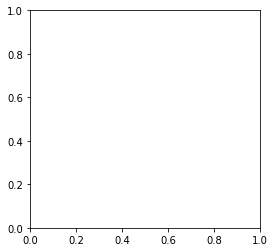

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2],fmt='o')
plt.subplot(132)
plt.errorbar(data[:,0],data[:,3],yerr=data[:,4],fmt='o')
plt.subplot(133)
plt.errorbar(data[:,0],data[:,5],yerr=data[:,6],fmt='o')

In [10]:
idx = 2
Day = data[idx][:,0]
Flux = data[idx][:,5]; Flux_err = data[idx][:,6]
PA = data[idx][:,3]; PA_err = data[idx][:,4]
Pi = data[idx][:,1] / 100; Pi_err = data[idx][:,2] / 100
deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

In [10]:
deg

8.974377356815264

In [289]:
offset = 0
helix = np.array([Bhelix((ph * deg + offset)* np.pi/180,0.2) for ph in range(22)])

In [375]:
Gamma = 10
theta_obs = 0.8 / Gamma #3 * np.pi/180
beta = np.sqrt(1-1/Gamma**2)
#theta_rot = np.arccos( (1/Gamma**2 - theta_obs**2) / (theta_obs**2 + 1/Gamma**2 - theta_obs**2 / (2 * Gamma**2) ) )
theta_rot = np.arccos( (1 - 0.8**2) / (1 + 0.8**2) )
#theta_rot = np.arccos((np.cos(theta_obs) - beta) / (1 - beta*np.cos(theta_obs)) )# - theta_obs
print(theta_rot)
#R1 = Rot(theta_obs)
R2 = Rot(theta_rot)
f = lambda x: np.arccos((np.cos(0.1) - np.sqrt(1-1/(x/0.1)**2)) / (1 - np.sqrt(1-1/(x/0.1)**2)*np.cos(0.1)) ) - 0.1

1.3494818844471053


In [792]:
 z = np.stack([-np.sin(theta_rot),np.cos(theta_rot),np.zeros(len(theta_rot))],axis=1)

In [810]:
coords.shape

(2, 62)

In [811]:
x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
_, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)

print(x0.shape)
print(th.shape)
B_mesh = np.stack([x0,x1,x2],axis=2)
axis_mesh = np.stack([y0,y1,y2],axis=2)

print(x[3,2])

(62, 17)
(62, 17)
[-0.04636525  0.02505294  0.99861034]


In [774]:
np.transpose(B_orig)[1]

array([-0.04165081,  0.03214275,  0.99861507])

Max ratio range for subjets is ratio_centre $\pm 1$, since max opening angle in jet frame is $45^{\circ}$

So to build a circular jet of subjets, can split into grid with $ratio$ as x axis and $\theta_{rot}$ as y axis

In [ ]:
ratio_range = 0.5 #max ratio_range = 1


In [851]:
deg = abs(max(PA[:,1]) - min(PA[:,1])) / abs(max(PA[:,0]) - min(PA[:,0]))

In [1090]:
X,Y,Z = np.meshgrid(np.linspace(0,1.5,50),np.linspace(0,1,50),np.linspace(-1.5,1.5,50))

In [68]:
logL(min(results)[1])

(1.5934944769889652, 3.820442494544469)

sign should be: 1
[0.15789473684210525, -1.473684210526316, -85.26315789473685, -14.21052631578948]
[  0.12301255  -2.07151155 -82.46983174  -9.18988099]


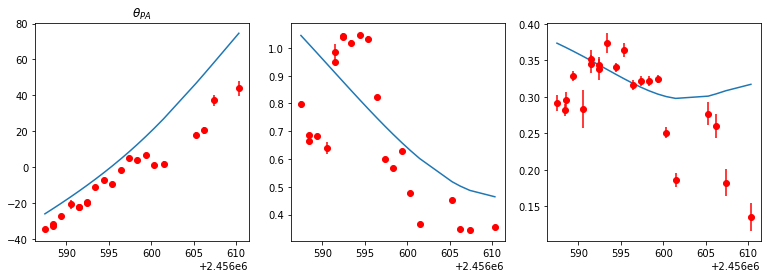

In [116]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001
sign = 1
def logL(X):
    ratio, ratio_range, pitch, offset = X
    _, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=sign, alpha=2, Gamma=10)
    loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
                  + abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )
    loss_flux = np.sum(abs(Flux - p_hat * max(Flux) / max(p_hat)) / Flux_err )
    #loss_pi = np.sum(abs(Pi - pi_hat) / Pi_err )
    #return loss_pa + delta1 * loss_flux + delta2 * loss_pi
    return loss_pa + delta * loss_flux
                              
#x0 = (np.random.uniform(0,1.5),np.random.uniform(0,0.999),np.random.uniform(-1.5,1.5))
print("sign should be: {}".format(results[0][1][-1]))
x0 = list(results[0][1])[:-1] #min(results)[1] #(0.57, 0.1, 0.1, -2.0)
print(x0)
res = minimize(logL, x0=x0, bounds=((0,1.5),(-4,4),(-180,180),(-90,90)))
print(res['x'])

pi_hat, pa_hat, p_hat = Jet(Day, res['x'][0], 0.1, res['x'][1], offset=res['x'][2], axis=res['x'][3], 
                            deg=deg, sign=sign, alpha=2, Gamma=10)
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.plot(Day,pa_hat)
plt.errorbar(Day, PA, yerr=PA_err, color='r',fmt='o')
plt.title(r"$\theta_{PA}$")
plt.subplot(132)
list1, list2 = zip(*sorted(zip(Day, p_hat * max(Flux) / max(p_hat))))
plt.plot(list1,list2)
plt.errorbar(Day, Flux, yerr=Flux_err, color='r',fmt='o')
plt.subplot(133)
plt.errorbar(Day, Pi, yerr=Pi_err, color='r',fmt='o')
plt.plot(Day,pi_hat-abs(max(Pi) - max(pi_hat)))


In [13]:
deg

3.4375571723071783

(9, 80, 3, 1e-06, 1, 0.5)
[7.50000000e+00 6.47764666e+01 2.05651314e+00 4.44704496e-07
 1.00000000e-03 5.00000000e-02]


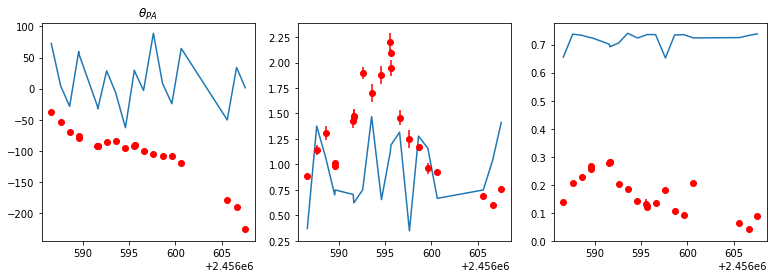

In [20]:
delta = 1.0
delta1 = 0.001
delta2 = 0.001
sign = 1
def logL(X):
    deg,offset,axis, a, b, c = X
    pi_hat, pa_hat, p_hat = Jet(Day, 0.7, 0.2, 0.1, offset=offset, deg=deg, axis=axis, sign=-1, alpha=2, Gamma=10)
    loss_pa = np.sum((np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat)))**2 / PA_err**2
                  + (np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat)))**2 / PA_err**2 )
    
    loss_flux = np.sum((Flux - (p_hat * a + b))**2 / Flux_err**2 )
    loss_pi = np.sum((Pi - (pi_hat + c))**2 / Pi_err**2 )
    #return loss_pa + delta1 * loss_flux + delta2 * loss_pi
    return delta * loss_pa + delta1 * loss_flux + delta2 * loss_pi
                              
x0 = (np.random.uniform(8.5,9.5),np.random.uniform(-180,180),np.random.uniform(-90,90))
x0 = (9,80,3,1e-6,1,0.5)
print(x0)
res = minimize(logL, x0=x0, bounds=((7.5,10.5),(-180,180),(-90,90),(1e-8,1e-4),(0.001,10),(0.05,0.7)) )
print(res['x'])

pi_hat, pa_hat, p_hat = Jet(Day, 0.7, 0.2, 0.1, offset=res['x'][0], deg=res['x'][1],axis=res['x'][2], 
                            sign=-1, alpha=2, Gamma=10)

plt.figure(figsize=(13,4))
plt.subplot(131)
plt.plot(Day,pa_hat)
plt.errorbar(Day, PA, yerr=PA_err, color='r',fmt='o')
plt.title(r"$\theta_{PA}$")
plt.subplot(132)
plt.plot(Day,p_hat*res['x'][3] + res['x'][4])
plt.errorbar(Day, Flux, yerr=Flux_err, color='r',fmt='o')
plt.subplot(133)
plt.errorbar(Day, Pi, yerr=Pi_err, color='r',fmt='o')
plt.plot(Day,pi_hat + res['x'][5])

### Grid Search
To identify good initial parameter spaces.

In [106]:
PA = PA[:-2]
Flux = Flux[:-2]
Pi = Pi[:-2]
Day = Day[:-2]

In [107]:
PA_err = PA_err[:-2]
Flux_err = Flux_err[:-2]
Pi_err = Pi_err[:-2]

In [20]:
np.linspace(2*0.8,2*1.2,5)

array([1.6, 1.8, 2. , 2.2, 2.4])

In [16]:
final_results = []
for datum in data[2:5]:
    Day = datum[:,0]
    Flux = datum[:,5]; Flux_err = datum[:,6]
    PA = datum[:,3]; PA_err = datum[:,4]
    Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
    deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))

    delta = 1.0
    delta1 = 0.001
    delta2 = 0.001
    def logL(X):
        ratio, ratio_range, pitch, offset, sign, deg = X
        pi_hat, pa_hat, p_hat = Jet(Day, ratio, ratio_range, pitch, offset, deg=deg, sign=sign, alpha=2, Gamma=10)
        #Do linear regression to find optimal axis value here
        b = np.ndarray.flatten(np.array([(np.cos(2*np.deg2rad(pa)),np.sin(2*np.deg2rad(pa))) for pa in PA]))
        A = np.concatenate([np.array([[np.cos(2*np.deg2rad(pa)),-np.sin(2*np.deg2rad(pa))],
                            [np.sin(2*np.deg2rad(pa)),np.cos(2*np.deg2rad(pa))]]) for pa in pa_hat],axis=0)
        
        w = np.ndarray.flatten(np.array([(err*2*np.sin(2*np.deg2rad(pa)),err*2*np.cos(2*np.deg2rad(pa))) for pa, err in zip(PA,PA_err)]))
        w = np.diag(1 / w) #weighted least squares
        x, loss_pa, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        axis = np.arctan2(x[1],x[0]) / 2
        Y = (ratio, ratio_range, pitch, offset, sign, np.rad2deg(axis))
        #loss_pa = np.sum(abs(np.cos(2*np.deg2rad(PA)) - np.cos(2*np.deg2rad(pa_hat))) / PA_err
                      #+ abs(np.sin(2*np.deg2rad(PA)) - np.sin(2*np.deg2rad(pa_hat))) / PA_err )
     
        A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
        w = np.diag(1 / Flux_err)
        b = Flux
        flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        
        A = np.concatenate([np.array([[pi,1]]) for pi in pi_hat],axis=0)
        w = np.diag(1 / Pi_err)
        b = Pi
        res = lsq_linear(np.matmul(w,A), np.matmul(w,b), bounds=[(0.99,-np.inf),(1.01, np.inf)])
        pi_offset = res['x'][1]
        loss_pi = 2 * res['cost']
        
        Y = (ratio, ratio_range, pitch, offset, sign, deg, np.rad2deg(axis), flux_scale, pi_offset)
        #np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
        
        #loss_flux = np.sum( (Flux - p_hat * max(Flux) / max(p_hat))**2 / Flux_err**2 )
        #loss_pi = np.sum((Pi - (pi_hat - abs(max(Pi) - max(pi_hat))) ) **2 / Pi_err**2)
        return (delta * loss_pa[0] + delta1 * loss_flux + delta2 * loss_pi, Y) 
    
    n_cpu = os.cpu_count()
    print(n_cpu)
    chunks = np.array( list(itertools.product(np.linspace(0.001,2.0,10),np.linspace(0.001,0.999,10), np.linspace(-4,4,10),
                                    np.linspace(-180,180,10),
                                    np.array([-1,1]), np.linspace(deg*0.9,deg*1.1,5))) )
    
    #remove chunks that have (ratio - ratio_range) > 1
    chunks = list(chunks[(chunks[:,0] - chunks[:,1]) <= 1.1])

    print("STARTING...")
    with mp.Pool(processes=n_cpu) as pool:
        results = pool.map(logL, chunks)
    print("DONE!")
    results.sort()
    print(results[0])
    final_results.append(results[0:10])

32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([7.56325348]), (0.6673333333333333, 0.33366666666666667, -0.44444444444444464, 20.0, -1.0, 8.076939621133738, 63.1855945913242, array([1.54726268e-07, 5.35357739e-01]), -0.4683320839778235))
32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([0.1121922]), (0.44522222222222224, 0.001, -0.44444444444444464, -100.0, 1.0, 7.356946468295639, 65.07827070998327, array([-1.74881297e-08,  5.31243886e-01]), -0.6564116262913184))
32
STARTING...


/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

DONE!
(array([0.34100164]), (0.6673333333333333, 0.44455555555555554, -0.44444444444444464, 140.0, -1.0, 11.518295815142933, 35.59938786510875, array([ 3.83553207e-07, -2.58199814e-01]), -0.5038924052735171))


In [17]:
final_results

[[(array([7.56325348]),
   (0.6673333333333333,
    0.33366666666666667,
    -0.44444444444444464,
    20.0,
    -1.0,
    8.076939621133738,
    63.1855945913242,
    array([1.54726268e-07, 5.35357739e-01]),
    -0.4683320839778235)),
  (array([7.69296517]),
   (0.44522222222222224,
    0.11188888888888888,
    -0.44444444444444464,
    20.0,
    -1.0,
    8.076939621133738,
    63.597977371411474,
    array([8.67264326e-08, 5.68523780e-01]),
    -0.5292116444787086)),
  (array([7.7636774]),
   (0.6673333333333333,
    0.33366666666666667,
    0.44444444444444464,
    -180.0,
    -1.0,
    8.5256584889745,
    51.98841081782494,
    array([1.62510728e-07, 4.57847876e-01]),
    -0.47882227321356213)),
  (array([7.7636774]),
   (0.6673333333333333,
    0.33366666666666667,
    0.44444444444444464,
    180.0,
    -1.0,
    8.5256584889745,
    51.98841081782493,
    array([1.62510728e-07, 4.57847876e-01]),
    -0.47882227321356213)),
  (array([7.76648951]),
   (0.44522222222222224,
    0

ValueError: setting an array element with a sequence.

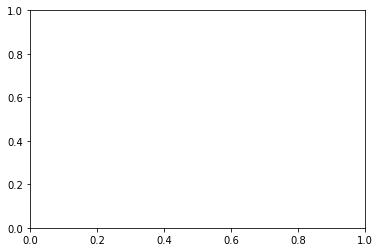

In [10]:
plt.hist([b for b in results[:]])

In [90]:
float(measured.loc[:,' gamma'][5])

1.06

In [13]:
x0 = list(results[20][1])

In [14]:
x0[7]

array([-2.49282016e-05,  4.50401564e+01])

In [99]:
len(measured)

10

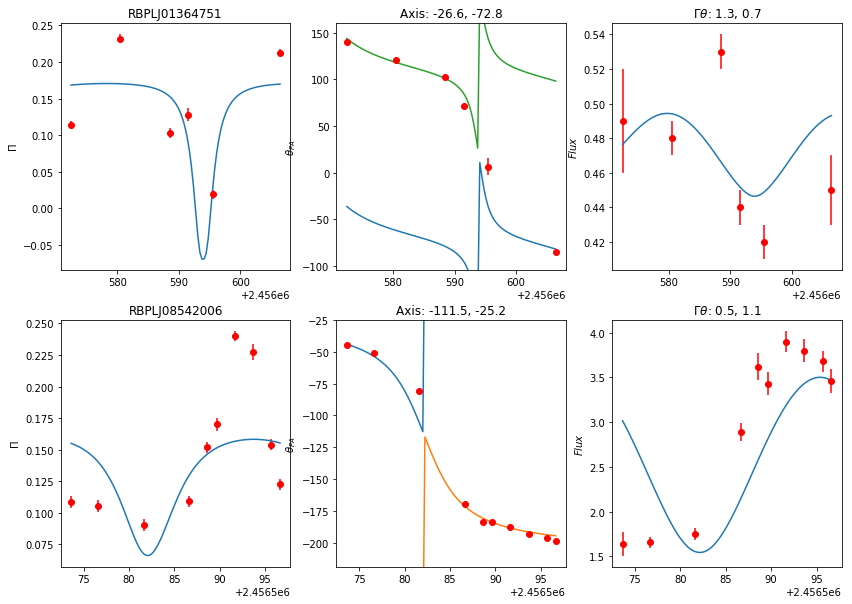

In [16]:
plt.figure(figsize=(14,10))
rows = len(final_results)
for i,result in enumerate(final_results):
    datum = data[i]
    Day = datum[:,0]
    Flux = datum[:,5]; Flux_err = datum[:,6]
    PA = datum[:,3]; PA_err = datum[:,4]
    Pi = datum[:,1] / 100; Pi_err = datum[:,2] / 100
    deg = abs(max(PA) - min(PA)) / abs(max(Day) - min(Day))
    
    x0 = list(result[0][1])
    x = np.linspace(Day[0],Day[-1],100)
    pi_hat, pa_hat, p_hat = Jet(x, x0[0], x0[1], pitch=x0[2], offset=x0[3], deg=x0[5], sign=x0[4], axis=x0[6], alpha=2, Gamma=10)
    plt.subplot(rows,3, 3*i + 1  ) 
    plt.title(blazars[i].replace(".dat",""))
    plt.ylabel(r"$\Pi$")
    plt.plot(x,pi_hat + x0[8])
    plt.errorbar(Day,Pi,yerr=Pi_err,c='r',fmt='o')
    
    plt.subplot(rows,3, 3*i + 2)
    try:
        plt.title("Axis: {:.1f}, {:.1f}".format(float(measured.loc[:,' PA'][i]),x0[6]))
    except ValueError:
        plt.title("Axis: None, {:.1f}".format(x0[5]))
    plt.ylabel(r"$\theta_{PA}$")
    plt.plot(x,pa_hat)
    plt.plot(x,pa_hat-180)
    plt.plot(x,pa_hat+180)
    plt.plot(x,pa_hat-360)
    plt.plot(x,pa_hat+360)
    plt.plot(x,pa_hat-540)
    plt.plot(x,pa_hat+540)
    plt.ylim(min(PA) - 20, max(PA) + 20)
    plt.errorbar(Day,PA,yerr=PA_err,c='r',fmt='o')
    
    plt.subplot(rows,3, 3*i + 3)
    try:
        plt.title(r"$\Gamma\theta$: {:.1f}, {:.1f}".format(float(measured.loc[:,' gamma'][i]) * 
                                          np.deg2rad(float(measured.loc[:,' theta'][i])) , x0[0]))
    except:
        plt.title("$\Gamma\theta$: None, {:.1f}".format(x0[0]))
    plt.ylabel(r"$Flux$")
    plt.plot(x,p_hat * x0[7][0] + x0[7][1])
    plt.errorbar(Day,Flux,yerr=Flux_err,c='r',fmt='o')

In [1171]:
def Jet(day, ratio, ratio_range, pitch, offset, deg, alpha, Gamma):
    """Helical jet of jets
    
    Args:
        day: 
        ratio: Gamma*theta of the jet centre.
        ratio_range: Opening angle of the jet.
        pitch: Magnetic Helix pitch angle.
        offset: In degrees.
        deg: Conversion from day to degrees.
        alpha: electron power law.
      
    Returns:
        Pi:
        PA:
        P:
    
    Raises:
        ValueError: Opening angle of jet too large.
    """
    if ratio_range > 1:
        raise ValueError("Jet opening angle can't be greater than 1/Gamma in Lab frame")
        
    day = day - np.min(day)
    B_orig = Bhelix((day*deg + offset) * np.pi/180, pitch)
    #Build jet of jets in multiple circles:
    coords = np.concatenate([pcircle(ratio, ratio_range, 30),pcircle(ratio, 5*ratio_range/6, 24), 
                             pcircle(ratio, 4*ratio_range/6, 18), pcircle(ratio, 3*ratio_range/6, 12),
                             pcircle(ratio, 2*ratio_range/6, 6), pcircle(ratio, 1*ratio_range/6, 2)],axis=1)
    #coords = np.expand_dims(np.array([ratio,0]),axis=1)
    theta_rot = np.arccos((1 - coords[0,:]**2) / (1 + coords[0,:]**2))
    x0,y0 = np.meshgrid(np.transpose(B_orig)[:,0],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,0])
    x1,y1 = np.meshgrid(np.transpose(B_orig)[:,1],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,1])
    x2,y2 = np.meshgrid(np.transpose(B_orig)[:,2],np.stack([-np.sin(coords[1,:]),np.cos(coords[1,:]),np.zeros(len(coords[1,:]))],axis=1)[:,2])
    _, th = np.meshgrid(np.transpose(B_orig)[:,2], theta_rot)
    B_mesh = np.stack([x0,x1,x2],axis=2)
    axis_mesh = np.stack([y0,y1,y2],axis=2)
    
    B = rotate(th, B_mesh, axis_mesh)
    #B shape = (coords,days,3)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:,:,:2]**2,axis=2)), B[:,:,2])
    weights = (Dapprox(Gamma,coords[0,:])**4 * flux_weight(Btheta, alpha).T).T #broadcast
    
    vec = B[:,:,:2][:,:,::-1]
    vec[:,:,1] *= -1
    PA = np.arctan2(vec[:,:,1],vec[:,:,0])
    S1 = np.sum(weights * np.cos(2 * PA),axis=0)
    S2 = np.sum(weights * np.sin(2 * PA),axis=0)
    Pi = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / np.sum(weights,axis=0)
    PA = np.rad2deg(np.arctan2(S2,S1) / 2 ) - 110 #jet axis
    P = np.sum(weights, axis=0)
    
    return Pi, PA, P

In [920]:
x = np.array([[1,2,3],[4,5,6]])
x[:,::-1]

array([[3, 2, 1],
       [6, 5, 4]])

In [921]:
D = lambda Gamma, theta: 1 / (Gamma * (1 - np.sqrt(1-1/Gamma**2)*np.cos(np.deg2rad(theta))))
Dapprox = lambda Gamma, ratio: 2 * Gamma / (1 + ratio**2)

In [741]:
print(D(10,8),Dapprox(10,10*np.deg2rad(8)))

6.804705917320545 6.78069194269854


In [ ]:
1 / Gamma * (1 - (1 - 1/(2*Gamma**2)) * (1 - theta**2/2))
2 / Gamma * (1/(Gamma**2) + theta**2)
2 / (1/(Gamma) + Gamma*theta**2)

In [692]:
D(20,1)**4 / D(20,3)**4

12.156067203699143

In [890]:
def F_flux(day,ratio,slope):
    offset = 5
    day = day - min(Flux[:,0])
    beta = np.sqrt(1-1/Gamma**2)
    theta_rot = np.arccos((1 - ratio**2) / (1 + ratio**2))
    B_orig = Bhelix((day*deg + offset) * np.pi/180, slope)
    R2 = Rot(theta_rot)
    #B_orig = np.matmul(R1,B_orig)
    B = np.matmul(R2,B_orig)
    Btheta = np.arctan2(np.sqrt(np.sum(B[:2]**2,axis=0)), B[2])
    return flux_weight(Btheta,2) * 2.2

In [901]:
def F(day,ratio,slope,up=None):
    offset = 0
    day = day - min(PA[:,0])
    #beta = np.sqrt(1-1/Gamma**2)
    theta_rot = np.arccos((1 - ratio**2) / (1 + ratio**2))
    B_orig = Bhelix((day*deg + offset) * np.pi/180, slope)
    R2 = Rot(theta_rot)
    #B_orig = np.matmul(R1,B_orig)
    B = np.matmul(R2,B_orig)
    print(B)
    if up is not None:
        if up == 1:
            B = np.matmul(RotX(0),B)
        else:
            B = np.matmul(RotX(-0),B)
            
    vec = np.matmul(np.array([[0,1],[-1,0]]),B[:2])
    #print(vec)
    return np.rad2deg(np.arctan2(vec[1,:],vec[0,:])) - 110

In [686]:
slope = 0.2
S2 = np.sin(2 * np.deg2rad(F(PA[:,0],0.7,slope))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.6,slope))) \
+ np.sin(2 * np.deg2rad(F(PA[:,0],0.8,slope))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.5,slope))) \
+ np.sin(2 * np.deg2rad(F(PA[:,0],0.6,slope,up=1))) + np.sin(2 * np.deg2rad(F(PA[:,0],0.7,slope,up=0)))
S1 = np.cos(2 * np.deg2rad(F(PA[:,0],0.7,slope))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.6,slope))) \
+ np.cos(2 * np.deg2rad(F(PA[:,0],0.8,slope))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.5,slope))) \
+ np.cos(2 * np.deg2rad(F(PA[:,0],0.6,slope,up=1))) + np.cos(2 * np.deg2rad(F(PA[:,0],0.7,slope,up=0)))
pi_hat = np.sqrt((0.7*S1)**2 + (0.7*S2)**2) / 6
PA_hat = np.rad2deg(np.arctan2(S2,S1) / 2 )

(3, 17)


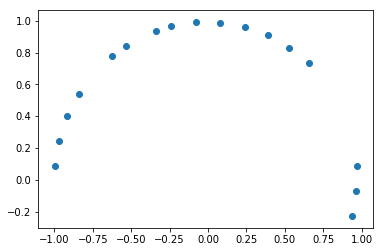

In [672]:
B_orig = Bhelix(((PA[:,0] - min(PA[:,0]))*deg + 5) * np.pi/180, 0.08)
print(B_orig.shape)
plt.scatter(B_orig[0,:],B_orig[1,:])

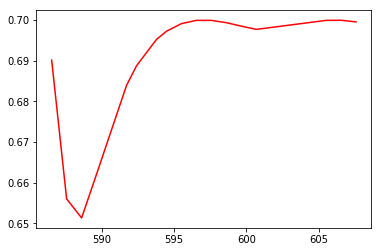

In [687]:
plt.plot(PA[:,0],pi_hat, 'r')

In [543]:
logL = lambda ratio: - np.sum((PA[:,1] - F(PA[:,0],ratio,0.05))**2)

[[ 0.33845887  0.34225615  0.33710611  0.20477045  0.15789304  0.10688798
   0.05308863 -0.00209856 -0.0572309  -0.11086709 -0.14509821 -0.20811818
  -0.23617392 -0.30271468 -0.32450288 -0.33780789 -0.34228188]
 [-0.14904227  0.01226196  0.17324563  0.80130884  0.88724664  0.94998992
   0.98789845  0.9999812   0.98592232  0.94608933  0.90570226  0.79391286
   0.72381096  0.46672648  0.31809917  0.16115606  0.        ]
 [-0.92910279 -0.93952668 -0.92538933 -0.56211495 -0.43343188 -0.29341797
  -0.1457335   0.00576076  0.15710442  0.30434104  0.39830882  0.57130481
   0.64832058  0.83098148  0.89079223  0.92731578  0.93959732]]


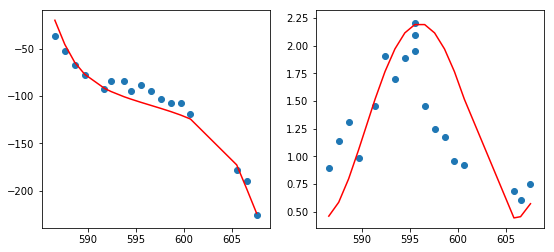

In [902]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(PA[:,0],F(PA[:,0],0.7,0.0), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.6,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.8,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.5,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.4,0.08), 'r')
#plt.plot(PA[:,0],F(PA[:,0],0.6,0.08,up=1), 'g')
#plt.plot(PA[:,0],F(PA[:,0],0.7,0.08,up=0), 'g')


plt.scatter(PA[:,0],PA[:,1])
plt.subplot(122)
plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.7,0.0), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.6,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.8,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.5,-0.05), 'r')
# plt.plot(np.sort(Flux[:,0]),F_flux(np.sort(Flux[:,0]),0.4,-0.05), 'r')
plt.scatter(Flux[:,0],Flux[:,1])

In [492]:
np.sort(Flux[:,0])

array([586.55172414, 587.5862069 , 588.62068966, 589.65517241,
       591.37931034, 592.4137931 , 593.44827586, 594.48275862,
       595.51724138, 595.51724138, 595.51724138, 596.55172414,
       597.5862069 , 598.62068966, 599.65517241, 600.68965517,
       605.86206897, 606.55172414, 607.5862069 ])

In [299]:
B_orig = np.transpose(helix)
B_orig = np.matmul(R1,B_orig)
B = np.matmul(R2,B_orig)
vecs = np.matmul(np.array([[0,1],[-1,0]]),B[:2])
Btheta = np.arctan2(np.sqrt(np.sum(B[:2]**2,axis=0)), B[2])

In [300]:
PA_hat = np.arctan2(vecs[1,:],vecs[0,:])
Flux_hat = flux_weight(Btheta)

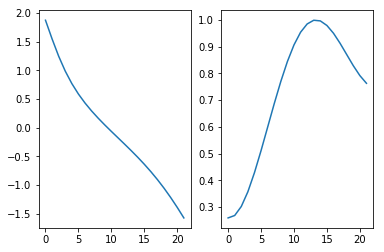

In [301]:
plt.subplot(121)
plt.plot(np.flip(PA_hat))
plt.subplot(122)
plt.plot(np.flip(Flux_hat))

In [78]:
np.transpose(np.matmul(R,np.transpose(helix))[:2]).shape

(22, 2)

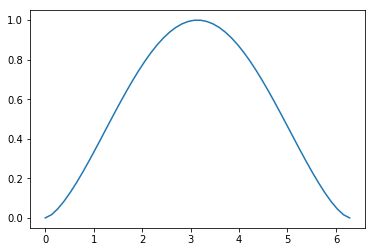

In [44]:
plt.plot([x for x in np.linspace(0,2*np.pi,50)],flux_weight([x for x in np.linspace(0,np.pi,50)]))